# parsing configuration file

In [1]:
import configparser
confParser = configparser.ConfigParser()

In [2]:
#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())

conf. file sections: ['parameters', 'flags', 'MsdAnalysis', 'EnergyBarrier', 'SroAnalysis', 'input files', 'Atomic Radius']


# import libraries

In [3]:
import sys
sys.path.append(confParser['input files']['lib_path'])

#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
import fnmatch
from scipy.optimize import curve_fit

#
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#--- user modules
import LammpsPostProcess as lp
#import LammpsPostProcess2nd as lpp
#import utilityy as utll
import utility as utl
#from utility import *
import imp
#imp.reload(lpp)
imp.reload(utl)
imp.reload(lp)
#imp.reload(utll)

<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

In [4]:
class Symbols:
    def __init__(self,
                markersizes=[10,10,10,12,12,12,10],
                ):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=markersizes
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        '''
        empty symbols
        '''
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

    def GetAttrsScatter(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=0.5):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            's':self.markersizes[count],
            'marker':self.markers[count],
#            'markerfacecolor':self.colors[count],
            'edgecolors':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
#            'markevery':nevery,
#           'errorevery':nevery,
#            'markeredgewidth':1.75,
            'linewidth':1, 
#            'barsabove':None,
#            'capsize':5,
#            'capthick':1,
#            'elinewidth':1,
#            'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    
class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

DRAW_FRAME=(0.23,0.08,0.12,0.07,0.01)
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    


# Dump File

In [5]:
class ParseConfiguration:
    '''
    Parse k-art configuration file
    '''
    
    def __init__(self,confParser,verbose=False):

        #--- fetch parameters defect_file
        self.datFile  = '%s/%s'%(confParser['input files']['input_path'],confParser['input files']['diffusion_file'])
        self.lib_path = confParser['input files']['lib_path']
        self.nsteps   = eval(confParser['parameters']['kmc_steps'])
        self.verbose  = verbose

    def Parse(self,fp, outpt):
        #--- parse dump: call ovito
        t0            = time.time()
        
        outpt_headers = 'dumpFile/calcResults.txt'
        #!ovitos $self.lib_path/OvitosCna.py $fp $outpt 1 7 $outpt_headers
        tmp = 2*self.nsteps+1
        !ovitos $self.lib_path/ovitoPyScripts.py -var InputFile $fp -var OutputFile $outpt -var nevery 1 -var AnalysisType 7 -var OutputFile_headers\
        $outpt_headers -var verbose True -var nframes $tmp
        
        if self.verbose:
            print('output dump file=%s s'%(time.time()-t0))

        #--- parse dump files
        if self.verbose:
            print('parsing %s'%(outpt))
        t0            = time.time()
        self.lmpData  = lp.ReadDumpFile( '%s'%(outpt) ) 
        self.lmpData.GetCords( ncount = 2*self.nsteps )
        if self.verbose:
            print('elapsed time=%s s'%(time.time()-t0))
            print('time steps:',self.lmpData.coord_atoms_broken.keys())
            display(self.lmpData.coord_atoms_broken[0].head())

        #--- add timescales
        self.lmpData.times = np.loadtxt(self.datFile)[:self.nsteps+1,0]

        #--- parse headers
        data = np.loadtxt(outpt_headers)
        if data.shape[1] == 4:
            self.lmpData.headers = pd.DataFrame(data[:2*self.nsteps+1],columns=["Barrier", "Energy", "Step", "Time"])
        elif data.shape[1] == 2:
            self.lmpData.headers = pd.DataFrame(data[:2*self.nsteps+1],columns=["Step", "Time"])


    def WignerSeitz(self,fp,reference_file):
        '''
        perform Wigner-Seitz algorithm
        '''
        outpt = 'dumpFile/dump_defect.xyz'

        #--- parse dump: call ovito
        if self.verbose:
            print('WignerSeitz analysis: input=',fp)
        t0=time.time()
        tmp = 2*self.nsteps+1
#         !ovitos $self.lib_path/OvitosCna.py $fp $outpt 1 11 $reference_file
        !ovitos $self.lib_path/ovitoPyScripts.py -var InputFile $fp -var OutputFile $outpt -var nevery 1\
        -var AnalysisType 11 -var verbose True -var nframes $tmp -var RefFile $reference_file
        if self.verbose:
            print('output dump file=%s s'%(time.time()-t0))
            
            


        #--- parse dump files
        if self.verbose:
            print('parsing %s'%(outpt))
        t0                  = time.time()
        self.lmpData_defect = lp.ReadDumpFile( '%s'%(outpt) ) 
        self.lmpData_defect.GetCords( ncount = 2*self.nsteps)
        if self.verbose:
            print('elapsed time=%s s'%(time.time()-t0))

        if self.verbose:
            print('time steps:',self.lmpData_defect.coord_atoms_broken.keys())
            display(self.lmpData_defect.coord_atoms_broken[0].head())

        #--- add timescales
        self.lmpData_defect.times = np.loadtxt(self.datFile)[:self.nsteps+1,0]


    def Print(self,fout):
        '''
        dump vacant sites
        '''
        
        times = list( self.lmpData_defect.coord_atoms_broken.keys() )
        times.sort()

        #--- print dump
        !rm $fout
        for ii in times:
            filtr = self.lmpData_defect.coord_atoms_broken[ii].Occupancy == 0.0
            df = self.lmpData_defect.coord_atoms_broken[ii][filtr]
            assert df.shape[0] == 1
            df.id=1;df.type=1
        #    print(df)
            atom_current = lp.Atoms(**df)
            box  = lp.Box( BoxBounds = self.lmpData_defect.BoxBounds[ii],  AddMissing = np.array([0.0,0.0,0.0] ))
            with open(fout,'a') as fp:
                lp.WriteDumpFile(atom_current, box).Write(fp, itime = ii,
                     attrs=['id', 'type','x', 'y', 'z'],
        #                 fmt='%i %i %15.14e %15.14e %15.14e',
                                                     )
                
    def Displacement(self, fp, fout,use_frame_offset=False):
        '''
        Return total displacements 
        '''
        !rm $fout

        #--- fetch  parameters
        fileCurr = fileRef = fp

        #--- call ovito
        t0 = time.time()
#        pdb.set_trace()
        tmp = 2*self.nsteps+1
        !ovitos $self.lib_path/ovitoPyScripts.py -var InputFile $fileCurr -var OutputFile $fout -var nevery 1\
         -var AnalysisType 8 -var verbose True -var nframes $tmp -var RefFile $fileRef -var use_frame_offset $use_frame_offset
#         !ovitos $self.lib_path/OvitosCna.py $fileCurr $fout 1 8 $fileRef $use_frame_offset
        if self.verbose:
            print('output disp:%s s'%(time.time()-t0))

        #--- parse disp files
        if self.verbose:
            print('parsing %s'%fout)
        t0 = time.time()
        self.lmpDisp = lp.ReadDumpFile( fout )
        self.lmpDisp.GetCords( ncount = 2*self.nsteps )
#         if self.verbose:
#             print('elapsed time %s s'%(time.time()-t0))
#             display(self.lmpDisp.coord_atoms_broken[0].head())

    def CommonNeighborAnalysis(self, fp, fout):
        '''
        common neighbor analysis
        '''
        !rm fout
        !ovitos $self.lib_path/OvitosCna.py $fp $fout 1 0

        #--- parse dump files
        print('parsing %s'%(fout))
        self.lmpCna = lp.ReadDumpFile( '%s'%(fout) ) 
        self.lmpCna.GetCords( ncount = sys.maxsize, 
                        )


    def Integrate(self):
        times = list(self.lmpDisp.coord_atoms_broken.keys())
        times.sort()
        x=list(map(lambda x:np.c_[self.lmpDisp.coord_atoms_broken[x].DisplacementX].flatten()[0],times))
        y=list(map(lambda x:np.c_[self.lmpDisp.coord_atoms_broken[x].DisplacementY].flatten()[0],times))
        z=list(map(lambda x:np.c_[self.lmpDisp.coord_atoms_broken[x].DisplacementZ].flatten()[0],times))
        X=np.cumsum(x)
        Y=np.cumsum(y)
        Z=np.cumsum(z)

        for itime, indx in zip(times,range(len(times))):
            self.lmpDisp.coord_atoms_broken[itime].DisplacementX=X[indx]            
            self.lmpDisp.coord_atoms_broken[itime].DisplacementY=Y[indx]
            self.lmpDisp.coord_atoms_broken[itime].DisplacementZ=Z[indx]
            
    def AddZero(self):
        self.lmpDisp.coord_atoms_broken[0] = self.lmpDisp.coord_atoms_broken[1]
        self.lmpDisp.coord_atoms_broken[0].DisplacementX=0.0
        self.lmpDisp.coord_atoms_broken[0].DisplacementY=0.0
        self.lmpDisp.coord_atoms_broken[0].DisplacementZ=0.0
        
    def PrintOvito( self, title ):
        #--- save
        try:
            os.system('rm %s'%title)
        except:
            pass
        times = list( self.lmpDisp_defect.coord_atoms_broken.keys() )
        times.sort()
        itime0 = times[ 0 ]
        rc = np.c_[ self.lmpDisp_defect.coord_atoms_broken[ itime0 ]['x y z'.split()] ]
        for itime in times:
            sfile        = open(title,'a')
            dx           = np.c_[self.lmpDisp_defect.coord_atoms_broken[ itime ]['DisplacementX  DisplacementY  DisplacementZ'.split()]]
            utl.PrintOvito(pd.DataFrame(np.c_[dx+rc].reshape(1,3),columns=['x','y','z']), 
                       sfile, 'itime=%s'%itime, attr_list=['x', 'y', 'z'])
            sfile.close()

## main()

In [ ]:
def main():
    !rm -r dumpFile; mkdir dumpFile; mkdir disp
    
    #--- parse allconf
    pc = ParseConfiguration(confParser,verbose=True)
    #
    pc.Parse('%s/%s'%(confParser['input files']['input_path'],confParser['input files']['dump_file']),
            'dumpFile/dump.xyz',
            )
    
    #--- vacancy dynamics based on ws analysis
    if eval(confParser['MsdAnalysis']['WignerSeitz']):
        pc.WignerSeitz('%s/%s'%(confParser['input files']['input_path'],confParser['input files']['dump_file']),
                       '%s/%s'%(confParser['input files']['input_path'],confParser['input files']['pure_crystal'])
                      )
        #--- output vacant sites
        pc.Print('dumpFile/dump_vacant.xyz')
    
    
        #--- vacancy disp
        pc.Displacement('dumpFile/dump_vacant.xyz',
                        'disp_vacant.xyz',
                       use_frame_offset = True, #--- velocity
                       )
        pc.AddZero() #--- add first timestep
        pc.Integrate() #--- get displacements
        pc.lmpDisp_defect = pc.lmpDisp
#         pc.PrintOvito('dumpFile/vacancy_trajectories.xyz')
        


    
    #--- total displacements
    pc.Displacement('dumpFile/dump.xyz',
                     'disp/disp.xyz')

    #--- vacant site based on cna analysis
#     pc.CommonNeighborAnalysis( 'dumpFile/dump.xyz',
#                      'disp/cna.xyz')

    #--- parse allconf_defect
    #--- vacant site based on defects
    pc_defect = ParseConfiguration(confParser,verbose=True)
    pc_defect.Parse('%s/%s'%(confParser['input files']['input_path'],confParser['input files']['defect_file']),
                    'dumpFile/dump_defects.xyz',

                   )

    #--- output timeseries
    !mkdir msd
    with open('msd/event_times.txt','w') as fp:
        np.savetxt(fp,pc.lmpData.times,header='t')
    #
    with open('msd/timeseries.txt','w') as fp:
        np.savetxt(fp,np.c_[pc.lmpData.headers],header='Barrier Energy Step Time')


    return pc, pc_defect

data, data_defect = main()



## pbc

In [ ]:
# times = list(data.lmpDisp_defect.coord_atoms_broken.keys())
# times.sort()

# x=list(map(lambda x:np.c_[data.lmpDisp_defect.coord_atoms_broken[x].DisplacementX].flatten()[0],times))
# y=list(map(lambda x:np.c_[data.lmpDisp_defect.coord_atoms_broken[x].DisplacementY].flatten()[0],times))
# z=list(map(lambda x:np.c_[data.lmpDisp_defect.coord_atoms_broken[x].DisplacementZ].flatten()[0],times))

# ax=utl.PltErr(None,None,Plot=False)
# #utl.PltErr(times[:-1],np.diff(x),ax=ax,Plot=False)
# utl.PltErr(times,x,ax=ax,Plot=False)
# # utl.PltErr(times[:-1],np.diff(y),ax=ax,Plot=False)
# # utl.PltErr(times[:-1],np.diff(z),ax=ax,Plot=False)

# utl.PltErr(None,None,title='disp/vel.png',ax=ax, yscale='linear',xlim=(0,75))

## msd vs. time

In [9]:
class MsDisp:
    
    def __init__(self, lmpDisp,  
                 filtr, 
                 lmpCna = None,
                 skip_times = 0):
        '''
        returns mean-squared displacements
        '''
        self.disp = lmpDisp.coord_atoms_broken
        try:
            self.cna = lmpCna.coord_atoms_broken
        except:
            pass
        self.times = list(lmpDisp.coord_atoms_broken.keys())
        self.times.sort()
        self.times = self.times[ skip_times: ]
#        print(self.times)
        self.filtr=filtr
        
    def Get(self,LOG=False):
        '''
        returns msd (no temporal window)
        '''
        if not LOG: #---  mean
            msd = list(map(lambda x:(self.disp[x]['DisplacementX']**2+\
                         self.disp[x]['DisplacementY']**2+\
                         self.disp[x]['DisplacementZ']**2).mean(),
                    self.times))
        else: #--- geometric mean
            msd = list(map(lambda x:10**((np.log10(self.disp[x]['DisplacementX']**2+\
                         self.disp[x]['DisplacementY']**2+\
                         self.disp[x]['DisplacementZ']**2)).mean()),
                    self.times))
        return np.array(msd)
        
    def GetPdfJumps(self):
        '''
        pdf's of jumps
        '''
        cols = ['DisplacementX','DisplacementY','DisplacementZ']
        for itime, itime0, count in zip(self.times[1:],self.times[:-1],range(len(self.times))):
            df=self.disp[itime][self.filtr]
            df0=self.disp[itime0][self.filtr]
            veloc = df[cols]-df0[cols]
            if count == 0:
                df_concat = np.c_[veloc]
            else:
                df_concat = np.concatenate([df_concat,veloc],axis=0) 
        df_abs = np.abs(df_concat.flatten())
        filtr = df_abs > 0.0
        
        hist, bin_edges, err = utl.GetPDF(df_abs[filtr],n_per_decade=4)
        utl.PltErr(bin_edges,hist, yerr=err,
                  yscale='log',
                   xscale='log',
        #           ylim=(1e-6,1e4)
                  )
        #
        with open('msd/event_jumps.txt','w') as fp:
            np.savetxt(fp,np.c_[bin_edges,hist,err],header='bin_edges hist err')

        
    def WindowAverage(self,ttime,bins_per_decade=4,LOG=False,nmin=1):
        '''
        returnd msd (include temporal windows)
        '''
        time_keys = np.arange(0,len(self.times),2) #--- ignore half step
        assert len(ttime) == len(time_keys), 'must be of the same size!'

        t0=time.time()
        cols = 'DisplacementX DisplacementY DisplacementZ'.split()
        for shift in range(1,len(time_keys)): #-1):
            dt = zip(time_keys,time_keys[shift:]) #--- time tuples
            dt_real = list(map(lambda x: x[1]-x[0], zip(ttime,ttime[shift:]))) #--- real time difference
            disp    = list(map(lambda x: np.c_[self.disp[x[1]][cols]-self.disp[x[0]][cols]].flatten(),zip(time_keys,time_keys[shift:])))
            if shift == 1:
                tr_mat=np.c_[dt_real,disp]
            else:    
                tr_mat = np.concatenate([tr_mat,np.c_[dt_real,disp]],axis=0)

        print('1st: t=%s'%(time.time()-t0))

        #--- remove dt == 0
        filtr1 = tr_mat[:,0] > 0
        #--- remove dr=0
        filtr2 = ~np.all([tr_mat[:,1]==0.0,tr_mat[:,2]==0.0,tr_mat[:,3]==0.0],axis=0)
        #---
        filtr = np.all([filtr1,filtr2],axis = 0 )
        tr_mat = tr_mat[filtr]
        
        
        return tr_mat #self.Binning(tr_mat,bins_per_decade,nmin=nmin)


    def WindowAverage2ndMethod(self,ttime,bins_per_decade=4,LOG=False):
        '''
        returnd msd (include temporal windows)
        '''

        time_keys = np.arange(0,len(self.times),2) #--- ignore half step
        assert len(ttime) == len(time_keys), 'must be of the same size!'
        
        tij = MsDisp.GetTijMatrix(ttime)
        t0 = time.time()
        xsq = self.GetXsqMatrix(time_keys,0)
        ysq = self.GetXsqMatrix(time_keys,1)
        zsq = self.GetXsqMatrix(time_keys,2)
#        print(xsq)
        print('2nd: t=%s'%(time.time()-t0))

                
        #--- remove dt == 0
        tij_flat = tij.flatten()
        filtr = tij_flat > 0.0
        usq = (xsq + ysq + zsq).flatten()
#         tr_mat = tr_mat[filtr]
# #        print('dt_min=',tr_mat[:,0].min())
# #        pdb.set_trace()
#        print('t,u=',tij_flat[filtr],usq[filtr])

        return MsDisp.Binning2nd(tij_flat[filtr],usq[filtr],bins_per_decade),\
               MsDisp.Binning2nd(tij_flat[filtr],usq[filtr],bins_per_decade, LogScale = False)

    def GetXsqMatrix(self,tlist, dim):
        n = len(tlist)
        xijsqMatrix = np.zeros(n*n).reshape((n,n))
        atom_indices = self.FiltrdAtoms(tlist) #--- rows corresponding to filtered frame
        key = ['DisplacementX','DisplacementY','DisplacementZ'][dim]
        for irow in range(n):
            for iatom in atom_indices: 
                x_peratom_timeseries = self.GetTimeSeriesPerAtom(iatom, tlist, key ) 
                xijsqMatrix[ irow ] +=  (x_peratom_timeseries - x_peratom_timeseries[ irow ])**2
        return xijsqMatrix / len(atom_indices)

    def GetTimeSeriesPerAtom(self, atomIndx, tlist, key, vacancy = False ):
        return list(map(lambda x:self.disp[x][key].iloc[atomIndx], tlist))


    def FiltrdAtoms(self,tlist):
        time0 = tlist[0]
        return self.disp[time0][self.filtr].index

    @staticmethod
    def GetTijMatrix(tlist):
        tlist = np.array(list(tlist))
        n = len(tlist)
        tijMatrix = np.zeros(n*n).reshape((n,n))
        t0 = time.time()
        for irow in range(n):
            tijMatrix[ irow ] = tlist - tlist[ irow ]
        return tijMatrix
    
    @staticmethod
    def Binning2nd(tlist,usq,bins_per_decade, LogScale = True):
        #--- binning
        xmin = 0.99*tlist.min()
        xmax = 1.01*tlist.max()
        if LogScale:
            n_decades = int(np.ceil(np.log10(xmax/xmin)))
            bins = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        else:
            bins = np.linspace(xmin,xmax,32)
        #
        ysum, edges = np.histogram(tlist,bins=bins,weights=usq)
        ysum_sq, edges = np.histogram(tlist,bins=bins,weights=usq*usq)
        xsum, edges = np.histogram(tlist,bins=bins,weights=tlist)
        count, edges = np.histogram(tlist,bins=bins)
        #
#        filtr = count > 1
        filtr = count > 0
        ysum = ysum[filtr]
        ysum_sq = ysum_sq[filtr]
        xsum = xsum[filtr]
        count = count[filtr]
        assert not np.any(count == 0), 'incerease bin size!'
        #
        ysum_sq /= count
        ysum /= count
        xsum /= count
        ysum_sq -= (ysum * ysum)
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[xsum,ysum,(ysum_sq/count)**0.5]
    
    def VacancyDynamics(self, title='void.xyz',
                       **kwargs):
        '''
        return xyz coordinates associated with vacancy 
        '''
        
        #--- unwrapped coordinates
        times            = self.times[1:]
        times_ref        = self.times[:-1]
            

        cols             = ['DisplacementX','DisplacementY','DisplacementZ']
        xsum_concat=np.array([0,0,0])
        for itime, itime_ref in zip(times,times_ref):
            df           = self.disp[itime]
            df0          = self.disp[itime_ref]
            veloc        = pd.DataFrame(np.c_[df0['id'],df[cols]-df0[cols]],columns=['id']+cols)
            #
#            filtr = self.cna[itime_ref]['StructureType'] == 0.0 #--- neighboring atoms
        #--- filter atom type
            if 'filtr_type' in kwargs:
                filtr = self.cna[itime_ref].type == eval(kwargs['filtr_type'])
                defect_atoms = self.cna[itime_ref][filtr].id
            else:
#                defect_atoms = self.cna[itime_ref].id
                defect_atoms_ref = self.cna[itime_ref].id
                defect_atoms_current = self.cna[itime].id
                defect_atoms = list(set(list(defect_atoms_ref)+list(defect_atoms_current)))

            veloc        = utl.FilterDataFrame(veloc,key='id',val=defect_atoms)
            #
            #indx_max     = np.argmax(list(map(lambda x:np.sum(x*x),np.c_[veloc[cols]])))

            xsum         = -np.array(veloc[cols].sum()) #---disp
            xsum_concat  = np.c_[xsum_concat,xsum]
        xsum_concat      = xsum_concat.T
        xv               = xsum_concat.cumsum(axis=0) #--- integrate
        #--- add initial position
        itime            = times_ref[0]
        if 'filtr_type' in kwargs:
            filtr = self.cna[itime].type == eval(kwargs['filtr_type'])
            defect_atoms = self.cna[itime][filtr].id
        else:
            defect_atoms     = self.cna[itime].id
        disps            = utl.FilterDataFrame(self.disp[itime],key='id',val=defect_atoms)
        rc               = np.array(disps[['x','y','z']].iloc[0]) #mean())
        #--- print
        try:
            os.system('rm msd/%s'%title)
        except:
            pass
        for itime in range(xv.shape[0]):
            sfile        = open('msd/%s'%title,'a')
            utl.PrintOvito(pd.DataFrame(np.c_[xv[itime,:]+rc].reshape(1,3),columns=['x','y','z']), 
                       sfile, 'itime=%s'%itime, attr_list=['x', 'y', 'z'])
            sfile.close()
        self.xv          = xv
        self.dxv         = xsum_concat
        
    def msdVacancy(self,ttime,bins_per_decade=4,LOG=False,nmin=1):
        '''
        returnd msd(t) associated with motion of the vacancy
        '''
        time_keys        =  np.arange(0,len(self.times),2) #--- ignore half step
        assert len(ttime)== len(time_keys), 'must be of the same size!'
        time_indices     = np.arange(len(time_keys))
        for shift in range(1,len(time_keys)):
            dt      = zip(time_keys,time_keys[shift:]) #--- time tuples
            dt_real = list(map(lambda x: x[1]-x[0], zip(ttime,ttime[shift:]))) #--- real time difference
            disp    = list(map(lambda x: self.xv[x[1]]-self.xv[x[0]],zip(time_indices,time_indices[shift:])))
            if shift== 1:
                tr_mat=np.c_[dt_real,disp]
            else:    
                tr_mat = np.concatenate([tr_mat,np.c_[dt_real,disp]],axis=0)
                
        #--- remove dt == 0
        filtr = tr_mat[:,0] > 0
        tr_mat = tr_mat[filtr]
        return self.Binning(tr_mat,bins_per_decade,nmin=nmin)


    def Binning(self,tr_mat,bins_per_decade, nmin=1):
        #--- binning
        xmin       = 0.99*tr_mat[:,0].min()
        xmax       = 1.01*tr_mat[:,0].max()
        n_decades  = int(np.ceil(np.log10(xmax/xmin)))
        bins       = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        
        #
        count, _   = np.histogram(tr_mat[:,0],bins=bins)
        tsum,  _   = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,0])
        filtr      = count >= nmin
        #  
        xsum, _    = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1])
        ysum, _    = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,2])
        zsum, _    = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,3])

        xsum_sq, _ = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1]*tr_mat[:,1])
        ysum_sq, _ = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,2]*tr_mat[:,2])
        zsum_sq, _ = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,3]*tr_mat[:,3])
        #
        xsum       = xsum[filtr]
        ysum       = ysum[filtr]
        zsum       = zsum[filtr]
        #
        xsum_sq    = xsum_sq[filtr]
        ysum_sq    = ysum_sq[filtr]
        zsum_sq    = zsum_sq[filtr]
        #
        tsum       = tsum[filtr]
        count      = count[filtr]
        assert not np.any(count < nmin), 'incerease bin size!'
        #
        xsum_sq   /= count
        ysum_sq   /= count
        zsum_sq   /= count
        #
        xsum      /= count
        ysum      /= count
        zsum      /= count
        #     
        tsum      /= count
        #
        xsum_sq   -= (xsum * xsum)
        ysum_sq   -= (ysum * ysum)
        zsum_sq   -= (zsum * zsum)
        assert np.all(xsum_sq >= 0) and np.all(ysum_sq >= 0) and np.all(zsum_sq >= 0)
        #
        var        = ( xsum_sq + ysum_sq + zsum_sq ) / 3.0
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[tsum,var,  np.sqrt(2.0/count) * var ] 


In [9]:
# def junk(**kwargs):
#     print(kwargs)

# junk()

### main()

In [10]:
def RandomChoice(lmpDisp):
    natom = lmpDisp.coord_atoms_broken[0].shape[0]
    size=np.min([natom,eval(confParser['MsdAnalysis']['natom'])])
    indices = np.random.choice(range(natom),replace=False,
                               size=size)
    assert indices.shape[ 0 ] == size
    filtr = np.zeros(natom,dtype=bool)
    filtr[ indices ] = True
    assert np.sum(filtr) == indices.shape[0], '%s %s' %(np.sum(filtr), indices.shape[0])
    
    return filtr

def main(data):
    
    if not eval(confParser['MsdAnalysis']['MsdAnalysis']):
        return
    
    
    !mkdir msd
    
    #----------------------------------
    #--- msd: dynamics of vacant site 
    #--- based on the cna analysis
    #----------------------------------
    msd          = MsDisp(data.lmpDisp, 
                         RandomChoice(data.lmpDisp), #--- filter 
                         data_defect.lmpData,
                        )
    #---  vacancy
    if eval(confParser['MsdAnalysis']['vacancy']):
        msd.VacancyDynamics(title='void2.xyz', 
                            **confParser['MsdAnalysis'])
        vac_data     = msd.msdVacancy(data.lmpData.headers['Time'][::2],
                                      bins_per_decade=4,LOG=False,nmin=10)
        #
        with open('msd/msd_vac_cna.txt','w') as fp:
#             np.savetxt(fp,vac_data,header='t\tmsd\terr')
             np.savetxt(fp,vac_data,header='t dx dy dz')

#    msd.GetPdfJumps() #--- jump distributions

     #--- msd
    if eval(confParser['MsdAnalysis']['total']):
        ans, ans_lin = msd.WindowAverage2ndMethod(data.lmpData.headers['Time'][::2],
                                                  bins_per_decade=4,LOG=False) #---msd
    
        with open('msd/msd.txt','w') as fp:
            np.savetxt(fp,ans,header='t\tmsd\terr')
        with open('msd/msd_lin.txt','w') as fp:
            np.savetxt(fp,ans_lin,header='t\tmsd\terr')
    #

        #--- correlated noise
    #     xvv = np.c_[list(map(lambda x:msd.dxv[x]+msd.dxv[x+1],range(1,msd.dxv.shape[0],2)))] #--- include half steps
    #     with open('msd/noise.txt','w') as fp:
    #         np.savetxt(fp,np.c_[lmpData.headers['Time'][1:-1:2],xvv],header='time dx dy dz')

        #---  filter based on atom types
        types      = list(set(data.lmpDisp.coord_atoms_broken[0]['type']))
        for itype in types:
            filtr  = data.lmpDisp.coord_atoms_broken[0]['type'] == itype
            msd    = MsDisp( data.lmpDisp,
                             filtr, #--- filter 
                             data_defect.lmpData
                           )
            ans, _ = msd.WindowAverage2ndMethod(data.lmpData.headers['Time'][::2],
                                               bins_per_decade=4,LOG=False)
            #--- print
            with open('msd/msd_type%s.txt'%itype,'w') as fp:
                np.savetxt(fp,ans,header='t\tmsd\terr')


    #--- correlated noise
#    xvv = np.c_[list(map(lambda x:msd.dxv[x]+msd.dxv[x+1],range(1,msd.dxv.shape[0],2)))] #--- include half steps
#    with open('msd/noise.txt','w') as fp:
#        np.savetxt(fp,np.c_[lmpData.headers['Time'][1:-1:2],xvv],header='time dx dy dz')

#     with open('msd/msd_logAveraged.txt','w') as fp:
#         np.savetxt(fp,ans_logAveraged,header='t\tmsd\terr')



    #----------------------------------
    #--- msd: dynamics of vacant site 
    #--- based on the ws analysis
    #----------------------------------
    if eval(confParser['MsdAnalysis']['WignerSeitz']):
        start_frame  = 0
        msd          = MsDisp( data.lmpDisp_defect, 
                              np.ones(data.lmpDisp_defect.coord_atoms_broken[start_frame].shape[0],dtype=bool) #--- filter 
                            )
        ans          = msd.WindowAverage(data.lmpData.headers['Time'][start_frame::2],
                                         bins_per_decade= 4,
                                         LOG            = False,
                                         nmin           = 10,
                                                 ) #---msd
        !mkdir msd
        with open('msd/msd_vac_ws.txt','w') as fp:
#             np.savetxt(fp,ans,header='t\tmsd\terr')
             np.savetxt(fp,ans,header='t dx dy dz')



main(data)

NameError: name 'data' is not defined

## Energy barriers

In [ ]:
class EnergyBarrier:
    '''
    return energy barriers corresponding to diffusional hopping
    '''
    def __init__(self,events_directory,evlist_directory,lmpData):
        self.events_dir = events_directory
        self.evlist_dir = evlist_directory
        self.lmpData = lmpData.coord_atoms_broken[0]
        
    def Parse(self):
        '''
        parse event files
        '''
        self.events_id_energy = self.ParseEvents_dir()
        self.catalog = self.ParseEvList_dir()
        
        
    def ParseEvents_dir(self):
        files = os.listdir(self.events_dir)
        d=[]
        for sfile in files:
            if not '.xyz' in sfile: #--- skip .xyz files 
                try:
                    filee=open('%s/%s'%(self.events_dir,sfile)) #--- open file
                    xstrs = filee.readlines()
                    event_id = int(xstrs[0].split()[-1]) #--- event id
                    barrier = float(xstrs[2].split()[-1]) #--- energy
                    ncluster =  int(xstrs[15].split()[-1])                 
                    shape_cluster_atoms =  int(xstrs[16].split()[-1])
                    atom_id = int(xstrs[17+ncluster].split()[0])
                    #print(atom_id)
                    d = np.c_[event_id,atom_id,barrier] if len(d) == 0 else\
                    np.concatenate([d,np.c_[event_id,atom_id,barrier]])
#                    d.setdefault(event_id,[]).append(barrier) #--- store
                except:
        #            traceback.print_exc()
                    continue
            
        #--- extract types
        df=self.lmpData
        atom_ids = d[:,1]
        types = utl.FilterDataFrame(df, 
                    key='id', 
                    val=atom_ids
                   )['type']

        return pd.DataFrame(np.c_[types,d],columns=['atom_type','event_id','atom_id','barrier'])

    def ParseEvList_dir(self):
        files = os.listdir(self.evlist_dir)
        events={}
        for sfile in files:
            try:
                kmc_step = int(sfile.split('_')[-1])
        #        print(kmc_step)
                filee=open('%s/%s'%(self.evlist_dir,sfile)) #--- open file
                events[kmc_step] = pd.read_csv(filee,delim_whitespace=True).iloc[1:]#delimiter='')
            except:
                continue
        return events
        
    def SplitByType(self):
        '''
        return energies (parsed from catalogs) slipt by atom types
        '''
        kmc_steps = list(self.catalog.keys())
        kmc_steps.sort()


        #--- dict based on types
        df_concat = {}
        types = list(set(self.lmpData.type))
        for itype in types:
            df_concat[str(itype)] = {}

        for kmc_step in kmc_steps: #--- kmc loop
            df = self.catalog[kmc_step]
            sdict=df.groupby(by='#TypeId').groups #--- group by type
            for itype in sdict:
                indices = sdict[itype] #--- row index: atoms with  '#TypeId' == itype
                cond = len(df_concat[itype]) == 0 #--- empty key?
                df_concat[itype] = np.c_[df.loc[indices]] if cond else\
                np.concatenate([df_concat[itype],np.c_[df.loc[indices]]],axis=0)

        self.energyByType = {}
        for itype in df_concat:
             self.energyByType[ itype ] = pd.DataFrame(df_concat[itype],columns=list(df.keys()))        



### main()

In [ ]:
def main(data):
    if not eval(confParser['EnergyBarrier']['EnergyBarrier']):
        return
    
    eb = EnergyBarrier('%s/EVENTS_DIR'%confParser['input files']['input_path'],
                       '%s/EVLIST_DIR'%confParser['input files']['input_path'],
                       data.lmpData

                      )
    eb.Parse()
    eb.SplitByType()

    #eb.events_id_energy extract from Events_dir
    #self.energyByType extract from catalogs

    #--- write to file
    !mkdir msd
    with open('msd/eventID_barrier.txt','w') as fp:
        np.savetxt(fp,
                   np.c_[eb.events_id_energy],
                   header='atom_type event_id atom_id barrier')

    #--- write to file: energy from catalogs
    for itype in eb.energyByType.keys():
        with open('msd/eventID_barrier_catalog_type%s.txt'%itype,'w') as fp:
        #--- concat different types
            sarr = np.c_[eb.energyByType[itype][['AtomId','eventId','barrier']]].astype(float)
            np.savetxt(fp,
                       sarr,
                       header='AtomId eventId barrier'
                      )
main(data)

## arrhenius law

In [114]:
class Temperature:
    def __init__(self,temp_range,nrun,verbose=False):
        self.temps =  temp_range
        self.nrun = nrun
        self.verbose = verbose
#         pdb.set_trace()
#        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],np.arange(x[1])),
#            zip(self.temps,self.nrun))))

        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        
    
    def BuildTempRealizationPair(self,temps,nrun):
        t,r=np.meshgrid(temps,nrun,indexing='ij')
        return np.array(list(zip(t.flatten(),r.flatten())))
        
    def ModifyNrun(self,dirs):
        #--- modify dirs
        count = -1
        dirs_copy = dirs[:]
        for _, indx in zip(self.temps,range(len(self.temps))):
            nrun_mod = self.nrun[indx][:]
            for y in self.nrun[indx]:
                count += 1
                x = dirs[count]
                if not os.path.isfile(x): #--- if false: remove file from "dirs"
                    dirs_copy.remove(x)
                    nrun_mod.remove(y)
            self.nrun[indx] = nrun_mod[:]

            assert len(self.nrun[indx]) > 0, 'temp = %s has no data!'%(self.temps[indx])
                
        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        return dirs_copy
        
    def Parse(self,dirs):
            
        dirs = self.ModifyNrun(dirs)
#         print('dirs:',dirs)
        self.data=list(map(lambda x:np.loadtxt(x,ndmin=2),dirs))
        if self.verbose:
            n = np.array(self.nrun).flatten()
            list(map(lambda x:print('Parsing: %s data.shape is: %s'%(x[1],x[0].shape)),zip(self.data,n)))
#        print('np.array(self.data):',np.array(self.data))

        
    def Plot(self,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        for data, temp_run, count in zip(self.data,self.temps_runs,range(len(self.data))): 
            temp = temp_run[0]
            try:
                utl.PltErr(data[:,0],data[:,1],
                       yerr=data[:,2],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
                       Plot=False,
                      )
            except:
                continue
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
#                 legend=legends.Get(),
                   **kwargs
                  )



    def Binning(self,tr_mat,bins_per_decade, nmin=1):
        #--- binning
        xmin       = 0.99*tr_mat[:,0].min()
        xmax       = 1.01*tr_mat[:,0].max()
        n_decades  = int(np.ceil(np.log10(xmax/xmin)))
        bins       = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        
        #
        count, _   = np.histogram(tr_mat[:,0],bins=bins)
        tsum,  _   = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,0])
        filtr      = count >= nmin
        #  
        xsum, _    = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1])
        ysum, _    = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,2])
        zsum, _    = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,3])

        xsum_sq, _ = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1]*tr_mat[:,1])
        ysum_sq, _ = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,2]*tr_mat[:,2])
        zsum_sq, _ = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,3]*tr_mat[:,3])
        #
        xsum       = xsum[filtr]
        ysum       = ysum[filtr]
        zsum       = zsum[filtr]
        #
        xsum_sq    = xsum_sq[filtr]
        ysum_sq    = ysum_sq[filtr]
        zsum_sq    = zsum_sq[filtr]
        #
        tsum       = tsum[filtr]
        count      = count[filtr]
        print('count=',count)
        assert not np.any(count < nmin), 'incerease bin size!'
        #
        xsum_sq   /= count
        ysum_sq   /= count
        zsum_sq   /= count
        #
        xsum      /= count
        ysum      /= count
        zsum      /= count
        #     
        tsum      /= count
        #
        xsum_sq   -= (xsum * xsum)
        ysum_sq   -= (ysum * ysum)
        zsum_sq   -= (zsum * zsum)
        assert np.all(xsum_sq >= 0) and np.all(ysum_sq >= 0) and np.all(zsum_sq >= 0)
        #
        var        = ( xsum_sq + ysum_sq + zsum_sq ) / 3.0
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[tsum,var, var*np.sqrt(2.0/count) ] 

    def Binning3rd(self,tr_mat,bins_per_decade, nmin=1):
        #--- binning
        xmin       = 0.99*tr_mat[:,0].min()
        xmax       = 1.01*tr_mat[:,0].max()
        n_decades  = int(np.ceil(np.log10(xmax/xmin)))
        bins       = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        
        tdata = tr_mat[:,0]
        xdata = tr_mat[:,1]
        ydata = tr_mat[:,2]
        zdata = tr_mat[:,3]
        tdata_concat = np.concatenate([tdata,tdata,tdata])
        rdata_concat = np.concatenate([xdata,ydata,zdata])
        #
        count, _   = np.histogram(tdata_concat,bins=bins)
        tsum,  _   = np.histogram(tdata_concat,bins=bins,weights=tdata_concat)
        filtr      = count >= nmin
        #  
        rsum, _    = np.histogram(tdata_concat,bins=bins,weights=rdata_concat)

        rsum_sq, _ = np.histogram(tdata_concat,bins=bins,weights=rdata_concat*rdata_concat)
        #
        rsum       = rsum[filtr]
        #
        rsum_sq    = rsum_sq[filtr]
        #
        tsum       = tsum[filtr]
        count      = count[filtr]
        assert not np.any(count < nmin), 'incerease bin size!'
        #
        rsum_sq   /= count
        #
        rsum      /= count
        #     
        tsum      /= count
        #
        rsum_sq   -= (rsum * rsum)
#         assert np.all(xsum_sq >= 0) and np.all(ysum_sq >= 0) and np.all(zsum_sq >= 0)
        #
        var        = rsum_sq #/ 3.0
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[tsum,var,  np.sqrt(2.0/count) * var ] 

    def EnsAverage2nd(self,
                   log_scale_x=False,log_scale_y=False,
                   col_x=0,col_y=1,
                   n_bins_per_decade=6,
                  n_thresh=0,
                   ymin=-sys.maxsize,ymax=sys.maxsize,
                      tmax=sys.maxsize
                  ):
        kount = 0
        self.data_averaged = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
#             if self.verbose:
#                 print('data.shape:',np.array(data).shape)
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             pdb.set_trace()
            filtr = data[:,0] <= tmax
            self.data_averaged[ temp ] = self.Binning3rd(data[filtr],n_bins_per_decade,nmin=n_thresh)

            kount += nruns #self.nrun
            
    def EnsAverage(self,
                   log_scale_x=False,log_scale_y=False,
                   col_x=0,col_y=1,
                   n_bins_per_decade=6,
                  n_thresh=0,
                   ymin=-sys.maxsize,ymax=sys.maxsize
                  ):
        kount = 0
        self.data_averaged = {} #np.zeros(len(self.temps))
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             print('np.array(data):',np.array(data))
#             pdb.set_trace()
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            self.data_averaged[ temp ] = self.hist(data,
                                                   log_scale_x,log_scale_y,
                                                   n_bins_per_decade=n_bins_per_decade,
                                                   col_x = col_x, col_y = col_y,
                                                   n_thresh=n_thresh,
                                                   ymin=ymin,ymax=ymax
                                                  )
            kount += nruns #self.nrun

    def hist(self,data,
             log_scale_x,log_scale_y,
             n_bins_per_decade=6,
             col_x = 0, col_y = 1,
             n_thresh=0,
                   ymin=-sys.maxsize,ymax=sys.maxsize
            ):
        n_thresh = n_thresh
#         pdb.set_trace()
            #--- average
        xdata = data[:,col_x]
        ydata = data[:,col_y]
        filtr = np.all([ydata>=ymin,ydata<ymax],axis=0)
        xdata = xdata[filtr]
        ydata = ydata[filtr]
        if log_scale_x:
            xmin = np.floor(np.log10(xdata).min())
            xmax = np.ceil(np.log10(xdata).max())
            n_decades = int((xmax - xmin))
            bins = np.logspace(xmin,xmax,n_decades*n_bins_per_decade)
        else:
            xmin = xdata.min()*0.999
            xmax = xdata.max()*1.001
            bins = np.linspace(xmin,xmax,n_bins_per_decade)
            
        #
        count, _    = np.histogram(xdata,bins=bins)
        xsum, _     = np.histogram(xdata,bins=bins,weights=xdata)
        weights     = ydata if not log_scale_y else np.log10(ydata)
        if log_scale_y and np.any(ydata == 0.0):
            print('data has a zero component!')
            return
        ysum, _     = np.histogram(xdata,bins=bins,weights=weights)
        ysum_sq, _  = np.histogram(xdata,bins=bins,weights=weights*weights)
        #
        xsum = xsum[count>n_thresh]
        ysum = ysum[count>n_thresh]
        ysum_sq = ysum_sq[count>n_thresh]
        count = count[count>n_thresh]
        #
        xsum /= count
        ysum /= count
        ysum_sq /= count
        assert np.all(ysum_sq - ysum * ysum >= 0.0), 'variance < 0.0!'
        std = np.sqrt((ysum_sq - ysum * ysum)/count)
        if log_scale_y:
            ysum = 10 ** ysum
            std = 0.5 * ysum * (1+2*std*np.log(10))
        return np.c_[xsum,ysum,std]
        
        
#            utl.PltErr(xsum,ysum,ax=self.ax)
            

    def PlotAverage(self,rescale=False,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5))
        for temp, count in zip(self.temps,range(len(self.temps))): 
            data = self.data_averaged[ temp ]
            xdata = data[:,0]
            ydata = data[:,1]
            yerr = data[:,2]
            if rescale:
                ydata /= xdata
                yerr /= xdata
            utl.PltErr(xdata,ydata,
                   yerr=yerr,
                   ax = self.ax,
                   attrs=symbols.GetAttrs(count=count%7 if not 'count' in kwargs else kwargs['count'],label=r'$%s$'%temp,nevery=1),
                   Plot=False,
                  )

        utl.PltErr(None,
                   None, 
                   ax=self.ax,
                   Plot=False,
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
        
    def func2nd(self,x,y0,c0,alpha):
#        return y0+c0*(x/x0)**alpha
        return y0*y0+c0*x**alpha

    def func3rd(self,x,c0,alpha):
         return c0*x**alpha

    def Fit(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5),
                   fontsize=18,
                   )

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            nruns = len(self.nrun[count])

            self.smat = smat = self.data_averaged[ temp ] if nruns > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1]
            yerr = smat[:,2]
#             print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func2nd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, #([1e-1, 1e5,0.5], [1e0, 1e7,2.0]), #[(4e-3, 1e5,0.5), (1e-2, 1e7,2.0)],#bounds,
                                    **kwargs
                                    )
            self.popt = popt
            self.pcov = pcov
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
                print('alpha=%s'%popt[2])
            y0=popt[0]
            alpha=popt[2]
            err_alpha = pcov[2,2]**0.5
            c0=popt[1]
            dc = pcov[1,1]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
            self.time_scale = tau * (y0/c0)**(1/alpha)
            if self.verbose:
                print('Temp=%s,tau=%s'%(temp,self.time_scale))
                print('err_alpha=%s'%err_alpha)
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                utl.PltErr(xdata_shift,
                                (self.func2nd(xdata,*popt)-y0),#-y0)/xdata_shift,
                                attrs={'fmt':'-.','color':symbols.colors[count%7],\
                                       'label':r'$\alpha=%3.2f$'%popt[2]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift,
                           (ydata-y0),#-y0)/xdata_shift,
                           yerr=(yerr),#-y0),#/xdata_shift,
#                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,fmt='.'),
                           attrs=symbols.GetAttrs(count=count%7,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
                         legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )

    def FitLinear(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            y0=0.0,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            nruns = len(self.nrun[count])
            self.smat = smat = self.data_averaged[ temp ] if nruns > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1] - y0*y0
            yerr = smat[:,2]
#             print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func3rd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, #([1e-1, 1e5,0.5], [1e0, 1e7,2.0]), #[(4e-3, 1e5,0.5), (1e-2, 1e7,2.0)],#bounds,
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
#            y0=popt[0]
            alpha=popt[1]
            err_alpha = pcov[1,1]**0.5
            c0=popt[0]
            dc = pcov[0,0]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
#            self.time_scale = tau * (y0/c0)**(1/alpha)
#            if self.verbose:
#                print('Temp=%s,tau=%s'%(temp,self.time_scale))
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
#                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                utl.PltErr(xdata_shift,
                                self.func3rd(xdata,*popt),
                                attrs={'fmt':'-.','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift,
                           ydata,
                           yerr=yerr,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
#                       legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )
            
    def PlotDiff(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.Diffusion[x][1]-self.Diffusion[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def PlotExponent(self,**kwargs):
        symbols=utl.Symbols()
        ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.exponent[x][0],self.temps)),
                   yerr=list(map(lambda x:1.0*(self.exponent[x][1]-self.exponent[x][2]),self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   ax=ax,
                   **kwargs
                  )


    



### main()

mkdir: png: File exists
single realizations
ensemble average


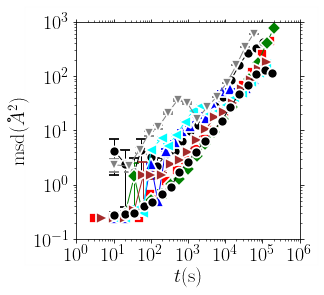

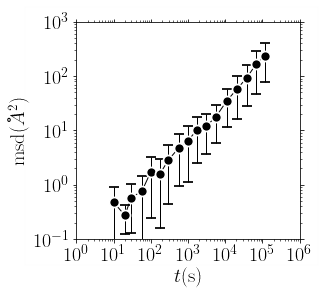

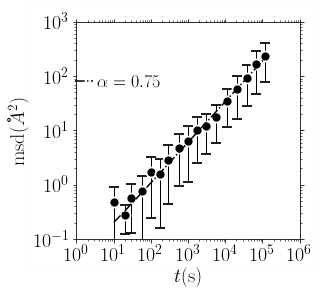

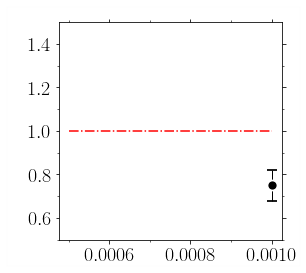

In [7]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    !mkdir png
    #--- temp object
    temp = Temperature(
        [1000],[list(range(8))]*10,
#          verbose = True,
                     )
    #
    #--- parse data
#    temp.Parse(['./msd/msd.txt']) 
#    temp.Parse( list(map(lambda x:'ni/void5th/Run%s/msd/msd.txt'%(x[1]),
    temp.Parse( list(map(lambda x:'ni/kmc/void_2d/Run%s/msd/msd_vac_cna.txt'%(x[1]),
#    temp.Parse( list(map(lambda x:'ni/pure/Run%s/msd/msd_vac_cna.txt'%(x[1]),
#    temp.Parse( list(map(lambda x:'ni/mlmc/latest_void5th/Run%s/msd/msd_vac_cna.txt'%(x[1]),
                         temp.temps_runs ))
             )
    #
    #--- plot
    xlim = (1e0,1e6)
#     xlim = (1e-10,1e-6)
    ylim = (1e-1,1e3)
    print('single realizations')
    temp.Plot(**{
                  'xscale':'log',
                  'yscale':'log',
                   'attrs':{'fmt':'-'},
                  'xlim':xlim,
                     'ylim':ylim,
                   'title':'png/msd_temp_ni.png',
                    'xstr':r'$t(\mathrm{s})$','ystr':r'$\mathrm{msd}(\r{A}^2)$',
        'bbox_to_anchor':(0.01,0.3,0.5,0.5)
    })
    
    #
    #--- plot average
    #
    print('ensemble average')
    temp.EnsAverage(log_scale_x=True,log_scale_y=True,
                   n_thresh=2,
                    n_bins_per_decade=4,#32,
#                     ymin=1e-3,
                   )
    temp.PlotAverage(**{
                  'yscale':'log',
                  'xscale':'log',
#                   'count':0,
                   'xlim':xlim,
                     'ylim':ylim,
                    'xstr':r'$t(\mathrm{s})$','ystr':r'$\mathrm{msd}(\r{A}^2)$',
                    'title':'png/msd_temp_ni_T%sK.png'%temp.temps[0],
         })

    #
    #--- fit
    #
    temp.Fit(Plot=True,
#              shift=True,
#             bounds=([4e-3, 1e5,0.5], [1e-2, 1e7,2.0]),
#            p0=[[1e-4, 1e6, 1.0]],
            p0=[[1e-1, 1e6, 1.5]],
               sigma=True, #--- comment for ni
              xlo=xlim[0],
             plotAttrs={'yscale':'log',
                  'xscale':'log',
                   'xlim':xlim,
                      'ylim':ylim,
                        'ndecade_x':1,
                    'bbox_to_anchor':(-0.05,0.33,0.5,0.5),
                   'title':'png/msd_temp_ni_fit_inset.png',
                    'xstr':r'$t(\mathrm{s})$','ystr':r'$\mathrm{msd}(\r{A}^2)$',
#                         'fontsize':24,
#              'halfopen':True
                       }
            )



    temp.PlotExponent(**{
                    'title':'png/alpha_temp_ni.png',
                    'ylim':(0.5,1.5),
                    }
                )
    
    return temp
temp = main()

### vacancy dynamics

In [142]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    #--- temp object
    temp_vac = Temperature(
#        [1000,1200,1400,1600,1800,2000],[[8,7,6,5,4,1,0],list(range(8)),list(range(8)),list(range(8)),list(range(8)),list(range(8))],
        [1000],[list(range(8))]*100,
         verbose = True,
                     )
    #
    #--- parse data
#    temp_vac.Parse(['./msd/msd_vac.txt'])
#    temp_vac.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
#    temp_vac.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
#    temp_vac.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd_vac.txt'%(x[0],x[1]),
#    temp_vac.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/msd_vac_cna.txt'%(x[0],x[1]),
    temp_vac.Parse( list(map(lambda x:'msd_definition/ni/temp0_6th/Run%s/msd/msd_vac_ws.txt'%(x[1]),
                          temp_vac.temps_runs ))
              )
    #
    #--- plot
#     print('single realizations')
#     temp_vac.Plot(**{
#                   'xscale':'log',
#                   'yscale':'log',
#                    'attrs':{'fmt':'-'},
# #                   'xlim':(1e-10,1e-3),
# #                    'ylim':(1e-5,1e-1),
# #                   'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
# #                   'title':'png/msd_temp_ni.png',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })
    #
    #--- plot average
    #
    if len(temp_vac.nrun[0]) > 1:
        print('ensemble average')
        temp_vac.EnsAverage2nd(log_scale_x=True,log_scale_y=True,n_bins_per_decade=6,n_thresh=1,tmax=3.296e-07)
    #
    #--- fit
#     temp_vac.Fit(Plot=True,
#              shift=False,
#              p0=[[0.4, 1e4, 1.1]],
#              sigma=True, #--- comment for ni
#                 xlo=1e-11, xhi=1e-7,
#                         ftol=1e-10, xtol=1e-10, gtol=1e-10,
#                         maxfev=10000,
#              plotAttrs={'yscale':'log',
#                   'xscale':'log',
#                         'ndecade_x':1,
#                     'bbox_to_anchor':(-0.05,0.4,0.5,0.5),
#                    'title':'png/msd_temp_ni_fit_vac_cna.png'},
#             )
    
#     temp_vac.FitLinear(Plot=True,
#              shift=True,
# #             bounds=([4e-3, 1e5,0.5], [1e-2, 1e7,2.0]),
#             p0=[[1e6, 1.0]],
# #             sigma=True, #--- comment for ni
# #             xlo=1e-12,
#              y0 = 0.7,
#              plotAttrs={'yscale':'log',
#                   'xscale':'log',
# #                   'xlim':(4e-13,8e-4),
# #                   'ylim':(1e-6,1e-2),
# #                     'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
#                         'ndecade_x':2,
#                     'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
#                    'title':'png/msd_temp_cantor_fit.png'},
#             )


#     temp.PlotDiff(**{
#                   'yscale':'log',
# #                   'xlim':(1e-12,1e-3),
# #                   'ylim':(1e-4,1e-1),
# #                   xstr=r'$1/T(K^{-1})$',
# #                   ystr=r'$D(m^2/s)$',
#                     'title':'png/D_temp_cantor.png',
#                     }
#                 )

#     temp_vac.PlotExponent(**{
# #                  'yscale':'log',
# #                   'xlim':(1e-10,1e-3),
# #                   'ylim':(.9,1.6),
# #                   xstr=r'$1/T(K^{-1})$',
# #                   ystr=r'$D(m^2/s)$',
#                     'title':'png/alpha_temp_ni_vac_cna.png',
#                     }
#                 )
    


mkdir: png: File exists
Parsing: 0 data.shape is: (320107, 4)
Parsing: 1 data.shape is: (320082, 4)
Parsing: 2 data.shape is: (320008, 4)
Parsing: 3 data.shape is: (320096, 4)
Parsing: 4 data.shape is: (320093, 4)
Parsing: 5 data.shape is: (320105, 4)
Parsing: 6 data.shape is: (320084, 4)
Parsing: 7 data.shape is: (320137, 4)
ensemble average
data.shape: (2560712, 4)


limits: 1e-10 1e-06
filtr= [False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

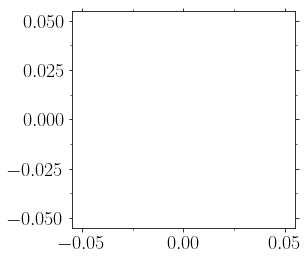

In [139]:
temp_vac.Fit(Plot=True,
             shift=False,
             p0=[[2.0, 1e11, 1.1]],
             sigma=True, #--- comment for ni
                 xlo=1e-10, xhi=1e-6,
                        ftol=1e-10, xtol=1e-10, gtol=1e-10,
                        maxfev=10000,
             plotAttrs={'yscale':'log',
                  'xscale':'log',
                        'ndecade_x':1,
                    'bbox_to_anchor':(-0.05,0.4,0.5,0.5),
                   'title':'png/msd_temp_ni_fit_vac_cna.png'},
            )

3.366e-07
3.296e-07
3.723e-07
3.955e-07
3.45e-07
3.381e-07
3.516e-07
3.529e-07


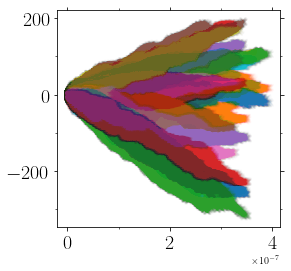

In [135]:

ax=utl.PltErr(None,None,Plot=False)
for irun in range(8):
    tdata = temp_vac.data[irun][:,0]
#     filtr = tdata <= 1.672e-07

    print(tdata.max())
    for idime in range(3):
        xdata = temp_vac.data[irun][:,idime+1]
    #
        utl.PltErr(tdata,xdata,
                  attrs={'fmt':'x','alpha':.01},
                   ax=ax,
                   Plot=False,
#                    xscale='log',
#                    yscale='log',
#                    ylim=(1e0,1e2),
                  )

# utl.PltErr(temp_vac.data_averaged[1000][:,0],
#           temp_vac.data_averaged[1000][:,1]**0.5,
# #           err=temp_vac.data_averaged[1000][:,2],
#           ax=ax,Plot=False,attrs={'fmt':'-o','color':'black'})


In [138]:
temp_vac.data_averaged[1000]

array([[1.00312500e-11, 2.02796429e+00, 2.92711432e-01],
       [2.00000000e-11, 1.78781076e+00, 3.64935343e-01],
       [2.70000000e-11, 6.83104343e-01, 5.57752361e-01],
       [3.56521739e-11, 2.13841156e+00, 2.57434500e-01],
       [5.00000000e-11, 2.31464919e+00, 3.28989910e-01],
       [6.97127660e-11, 2.37076284e+00, 1.99654248e-01],
       [1.00395695e-10, 2.56974059e+00, 5.76633225e-02],
       [1.49236486e-10, 2.84618233e+00, 1.91023250e-01],
       [2.02481065e-10, 3.36139666e+00, 7.12454582e-02],
       [3.02378238e-10, 3.95079587e+00, 8.33456724e-02],
       [4.49170028e-10, 4.79775216e+00, 7.36895834e-02],
       [6.45641347e-10, 5.87594193e+00, 8.80346499e-02],
       [8.99179778e-10, 6.83420773e+00, 8.48789825e-02],
       [1.29680843e-09, 9.21181151e+00, 8.82007907e-02],
       [1.85338743e-09, 1.20088116e+01, 1.02081649e-01],
       [2.65154619e-09, 1.67312213e+01, 1.13051373e-01],
       [3.79785780e-09, 2.35006926e+01, 1.37065816e-01],
       [5.40561579e-09, 3.54139

29


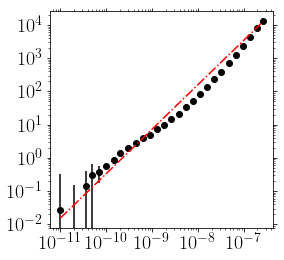

[1.95000076e-04 8.07459342e+12 1.33849685e+00]


In [141]:
xdata = temp_vac.data_averaged[1000][:,0]
ydata = temp_vac.data_averaged[1000][:,1]
yerr  = temp_vac.data_averaged[1000][:,2]
# filtr = xdata < 1e-1
# xdata = xdata[filtr]
# ydata = ydata[filtr]
# yerr = yerr[filtr]
print(len(xdata))
ax = utl.PltErr(None,None,Plot=False)
utl.PltErr(xdata,ydata, yerr=yerr,
           attrs={'fmt':'o','color':'black'},
          xscale='log',yscale='log',
           ax=ax,
           Plot=False
          )

popt, pcov = curve_fit(temp_vac.func2nd, xdata, ydata,
             p0=[[0.4, 1e5, 1.1]],
                       ftol=1e-10, xtol=1e-10, gtol=1e-10,
                       maxfev=10000,
                        )

utl.PltErr(xdata,temp_vac.func2nd(xdata,*popt),
           attrs={'fmt':'-.','color':'red'},
          xscale='log',yscale='log',
           ax=ax
          )

print(popt)

In [ ]:
# np.savetxt('msd/msd_cna.txt',np.c_[temp_vac.data_averaged[1000]])
# np.savetxt('msd/msd_cna_opt.txt',np.c_[temp_vac.popt])
# np.savetxt('msd/msd_cna_cov.txt',np.c_[temp_vac.pcov])

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    symbols=utl.Symbols()
    legends = Legends()
    legends.Set(bbox_to_anchor=(0.1,0.5,0.5,0.5))
    #
    ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
    utl.PltErr(1.0/np.array(temp.temps),
               list(map(lambda x:temp.exponent[x][0],temp.temps)),
               yerr=list(map(lambda x:1.0*(temp.exponent[x][1]-temp.exponent[x][2]),temp.temps)),
               attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Total}$'),
               ax=ax,
               Plot=False,
    #           **kwargs
              )

    utl.PltErr(1.0/np.array(temp_vac.temps),
               list(map(lambda x:temp_vac.exponent[x][0],temp_vac.temps)),
               yerr=list(map(lambda x:1.0*(temp_vac.exponent[x][1]-temp_vac.exponent[x][2]),temp_vac.temps)),
               attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Vacancy}$'),
               DrawFrame=DRAW_FRAME,
               ax=ax,
                       ylim=(.5,1.5),
#               halfopen=True,
#               legend=legends.Get(),
                        title='png/alpha_temp_cantor.png',
              )


### robustness

In [ ]:
class Robustness(Temperature):
    
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun,verbose=verbose)

    def FitRange(self,decades=9):
        self.Fit(Plot=False,shift=False,
                    p0=[[1e-2, 1e6, 1.0]],
                 sigma=True, #--- comment for ni
                     plotAttrs={'bbox_to_anchor':(-0.05,0.23,0.5,0.5)}
                )

        self.xlo = np.floor(np.log2(self.smat[:,0].min()))
        xhii = np.ceil(np.log2(self.smat[:,0].max()))
        self.xrange = 2**np.arange(xhii+1,xhii-decades,-1)
        
    def Fitting(self):
        #--- bounds
        self.exponents = np.zeros(len(self.xrange))
        self.error = np.zeros(len(self.xrange))
        self.npoin = np.zeros(len(self.xrange))
        
        npoint_filtrd0 = self.smat.shape[0]
        for xhi, indx in zip(self.xrange,range(len(self.xrange))):
            self.Fit(Plot=True,
                     shift=False,
        #             bounds=([0, 0, 0,0.999], [1e-2, 1e-3, 1,1.001]),
                        p0=[[1e-2, 1e6, 1.0]],
                     sigma=True, #--- comment for ni
                     xlo=2**self.xlo,xhi=xhi,
                     plotAttrs={'yscale':'log',
                          'xscale':'log',
        #                   'xlim':(4e-13,8e-4),
        #                   'ylim':(1e-4,1e-1),
        #                     'xstr':r'$t\mathrm{(s)}$',
        #                   'ystr':r'msd(A$^2$)',
                                'ndecade_x':2,
                            'bbox_to_anchor':(-0.05,0.23,0.5,0.5),
    #                       'title':'png/msd_temp_nicocr_fit.png'
                               },
                    )
            
            #--- check if decrease in tc leads to fewere points
#             npoint_filtrd = np.sum(self.filtr)
#             if self.verbose:
#                 print('npoint_filtrd=',npoint_filtrd)
#             #if indx > 0:
#             if npoint_filtrd == npoint_filtrd0 and indx > 0:
#                 continue
# #                    , '%s >= %sdecrease ndecades!'%(npoint_filtrd,npoint_filtrd0)
#             npoint_filtrd0 = npoint_filtrd
            
            #--- assign
            self.npoin[indx] = np.sum(self.filtr)
            if self.npoin[indx] == self.npoin[indx-1] and indx > 0:
                continue
            self.exponents[indx] = self.popt[-1]
            x = self.temps[ 0 ]
            self.error[indx] = 0.5*(self.exponent[x][1]-self.exponent[x][2])
        
if not eval(confParser['flags']['RemoteMachine']):

    symbols = utl.Symbols()
    ax = utl.PltErr(None,None,Plot=False)

    temps = [1200] #[1000,1200,1400,1600,1800,2000]
    indices = [1] #range(10)
    for temperature, indx in zip(temps,indices):
        try:
            rb = Robustness([temperature],8,
#                            verbose = True

                            )

            #--- parse data
#            rb.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd.txt'%(x[0],x[1]),
            rb.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
#            rb.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
                                rb.temps_runs ))
                     )

            #--- plot average
            if rb.nrun > 1:
                print('ensemble average')
                rb.EnsAverage(log_scale=False,n_bins_per_decade=4)
#                 rb.PlotAverage(**{
#                           'yscale':'log',
#                           'xscale':'log',
#         #                   'xlim':(1e-10,1e-3),
#         #                   'ylim':(1e-4,1e-1),
#         #                     'xstr':r'$t\mathrm{(s)}$',
#         #                   'ystr':r'msd(A$^2$)',
# #                            'title':'png/msd_temp_cantor.png',
#                 })
            #
            #--- fit
            #
            rb.FitRange(decades=10)
            rb.Fitting()


            #--- get data
            filtr = np.all([rb.exponents>0,rb.exponents<2],axis=0)
            utl.PltErr(rb.xrange[filtr],rb.exponents[filtr],yerr=rb.error[filtr],
                       attrs=symbols.GetAttrs(count=indx%7),
                       ax=ax,
                        Plot=False,
                      )
        except:
            print('increase fit range!')
            traceback.print_exc()
            continue

    utl.PltErr(ax.axis()[:2],[1,1],Plot=False,ax=ax,
                attrs={'fmt':'-.','color':'red'},
                       ylim=(0,2),
                      xscale='log',
                       DrawFrame=DRAW_FRAME,
                       title='png/exponentH_ni_T%sK.png'%temperature,
              )

### per type

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    ax = utl.PltErr(None,None,Plot=False)
    symbols=utl.Symbols()
    legends = Legends()
    legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
 
                       
    ntype = 5
    for itype in range(1,ntype+1):
        temp = Temperature(#[1000],3
                           list(map(int,np.linspace(1000,1400,11))),3
                          )
        temp.Parse( list(map(lambda x:'CantorNatom16KTemp%sK_ensemble/Run%s/msd/msd_type%s.txt'%(x[0],x[1],itype),
                            temp.temps_runs ))
                  )
        #
  #      print('single realizations')
  #      temp.Plot()
        #
        print('ensemble average: type %s'%itype)
        temp.EnsAverage()
#         temp.PlotAverage()
#         #
        temp.Fit(#Plot=True,
        #         verbose=True
        )
#         temp.PlotDiff()
        
        #--- plot
        utl.PltErr(1/np.array(list(temp.Diffusion.keys())),
                   list(map(lambda x:temp.Diffusion[x],list(temp.Diffusion.keys()))),
                       Plot=False,
                   ax=ax,
                   attrs=symbols.GetAttrs(count=(itype-1)%7,label=r'$%s$'%temp),
                 )
    utl.PltErr(None,None,
               ax=ax,
               yscale='log',
               ylim=(1e-15,1e-11),
              xstr=r'$1/T(K^{-1})$',
              ystr=r'$D(m^2/s)$',
              )

In [ ]:
#tauu = temp.time_scale

## correlated noise

In [ ]:
class Noise(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotNoise(self, col_a = 1, col_b=1,
                  **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        self.crltns_mean_ab = {}
        self.crltns_mean_ba = {}
        self.crltns_err_ab = {}
        self.crltns_err_ba = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
                
            #--- correlations
            crltns_ab = np.c_[list(map(lambda x: Noise.Crltns(x[:,col_a],x[:,col_b]),data))]
            crltns_ba = np.c_[list(map(lambda x: Noise.Crltns(x[:,col_b],x[:,col_a]),data))]
            self.crltns_mean_ab[temp] = np.mean(crltns_ab,axis=0)
            self.crltns_mean_ba[temp] = np.mean(crltns_ba,axis=0)
            self.crltns_err_ab[temp] = np.std(crltns_ab,axis=0)/self.nrun**0.5
            self.crltns_err_ba[temp] = np.std(crltns_ba,axis=0)/self.nrun**0.5
            kount += self.nrun
        #--- plot
        irun = 0
        smat=data[irun]
        for i,j in zip(smat[:,0],smat[:,col_a]):
            utl.PltErr([i,i],[0,j],
                       attrs={'fmt':'-','color':'C0'},
                       ax=self.ax,
                       Plot=False,
#                       **kwargs
                      )
        utl.PltErr(self.ax.axis()[:2],[0,0],
                        ax=self.ax,
                   DrawFrame=DRAW_FRAME,
                       **kwargs
                       )

            
        
    def PlotSum(self, col_a = 1, col_b=1,
                  **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
                
            #--- correlations
            #--- plot
            irun = 0
            smat=data[irun]
            utl.PltErr(smat[:,0],np.cumsum(smat[:,col_a]),
                       attrs={'drawstyle':'steps-post'},
                       ax=self.ax,
                       Plot=False,
                   DrawFrame=DRAW_FRAME,
                       **kwargs
                      )

#             utl.PltErr(lmpData.headers['Time'][1:-1:2],np.cumsum(xvv[:,2]),
#                       attrs={'drawstyle':'steps-post'},
#                       )

            
            kount += self.nrun
        
    @staticmethod        
    def Crltns(a,b,n=10):
        cr,err=Noise.CrossCr(a,b)
        return cr[:n] #np.c_[cr,err]
    
    def zscore(slist):
        slist -= np.mean(slist)
        slist /= np.std( slist )
        return slist

    def CrossCr(x,y, ZSCORE = True):
        if ZSCORE:
            x -= np.mean( x )
            y -= np.mean( y )

            x /= np.std( x )
            y /= np.std( y )
        assert len(x) == len(y), 'len(x)=%s,len(y)=%s'%(len(x),len(y))
        n = len(x)
        x=np.concatenate([x,np.zeros(n)],axis=0)
        y=np.concatenate([y,np.zeros(n)],axis=0)
        ones = np.concatenate([np.ones(n),np.zeros(n)],axis=0)

        X=np.fft.fft(x)
        Y=np.fft.fft(y)
        Z=X.conjugate()*Y

        cq = np.fft.fft( ones )
        count = np.fft.ifft( cq.conjugate()*cq ).real[:n]

        z=np.fft.ifft(Z)[:n] / count

        return z, 1.0/np.sqrt(count)




    def PlotCrltns(self,**kwargs):

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        
        ax = utl.PltErr(None,None,Plot=False)
        for temp, indx in zip(self.temps,range(len(self.temps))):
            n=noise.crltns_mean_ba[temp].shape[0]
            x=np.concatenate([-np.arange(n-1,-1,-1),np.arange(n)])
            indices=np.arange(n-1,-1,-1)
            y=np.concatenate([noise.crltns_mean_ba[temp][indices],
                              noise.crltns_mean_ab[temp]])
            yerr=np.concatenate([noise.crltns_err_ba[temp][indices],
                              noise.crltns_err_ab[temp]])


            utl.PltErr(x,
                       y,
                       yerr=2*yerr,
                       attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp),
                       Plot=False,
                       ax=ax,
                      )
            
        utl.PltErr(ax.axis()[:2],[0,0],
                   attrs={'fmt':'-.r'},
                   Plot=False,
            DrawFrame=DRAW_FRAME,
                   ax=ax,
                       **kwargs
                  )
    

if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    #--- temp object
    noise = Noise(
#        [1000,1200,1400,1600,1800,2000],8,
        [2000],8,
#         verbose = True,
                     )
    #
    #--- parse data
#    noise.Parse(['./msd/noise.txt'])
#    temp.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/msd.txt'%(x[0],x[1]),
    noise.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/noise.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
#    temp.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/msd.txt'%(x[0],x[1]),
                        noise.temps_runs ))
             )
    #
    #--- plot
    noise.PlotNoise(col_a=1,col_b=1,**{
#                   'attrs':{'fmt':'-','color':'C0'},
#                   'xlim':(0,0.5e-09),
#                    'ylim':(-2,2),
#                     'xticks':([r'$0$',r'$2$',r'$4$'],[0,2e-10,4e-10]),
#                   'title':'png/noise_z_nicocr.png',
#                   'bbox_to_anchor':(0.01,0.3,0.5,0.5)
    })
    #
    #--- plot sum
#     noise.PlotSum(col_a=1,col_b=1,**{
# #                  'xscale':'log',
# #                  'yscale':'log',
#                    'xlim':(0,1e-09),
# #                    'ylim':(1e-5,1e-1),
# #                   'xstr':r'$t\mathrm{(s)}$',
# #                   'ystr':r'msd(A$^2$)',
# #                   'title':'png/msd_temp_ni.png',
#         'bbox_to_anchor':(0.01,0.3,0.5,0.5)
#     })

    
    #
    noise.PlotCrltns(
        **{
#                   'yscale':'log',
#                   'xscale':'log',
#                   'xlim':(1e-10,1e-3),
#                    'ylim':(1e-4,1e-1),
#                     'xstr':r'$t\mathrm{(s)}$',
#                   'ystr':r'msd(A$^2$)',
                   'title':'png/noiseCrltn_yz_nicocr.png',
        })



## wait times

In [ ]:
class Stats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotWaitTimes(self,scale=False,
                      scalePowerLaw=False,
                      shift=False,
                      n_per_decade=6,
                      **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            nruns = len(self.nrun[indx])
            #--- concat. data for each temp
            data = self.data[kount:kount+nruns]
            data = list(map(lambda x:self.GetWaitTimes(x),data))
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            data = np.concatenate(data) #,axis=0)
            rate = 1.0 / data.mean()
            self.mean_rate[temp] = [ rate, rate*(1/len(data)**0.5)]
            if scale:
                data /= data.mean() 
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
            hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)
            if scalePowerLaw:
                alpha = 2 #1.5
                hist *= bin_edges ** alpha 
                err *= bin_edges ** alpha 
            #--- plot
            if shift:
                hist *= 10 ** indx 
                err *= 10 ** indx 
            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
            kount += nruns
        self.data_regr = np.c_[bin_edges,hist,err]
        #
        xhi=self.ax.axis()[1]
        xarr = np.logspace(np.log10(xhi)-5.0,np.log10(xhi),32)
        utl.PltErr( xarr if scale else None,
                   np.exp(-xarr) if scale else None,
                   attrs={'fmt':'-.r','lw':2},
                   ax=self.ax,
                   Plot=False,
                   
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    def PlotAverageRate(self,**kwargs):
#        print(list(self.temps_runs))
#         self.ax = utl.PltErr(None,#ans[:,0],
#                         None,#1e8*ans[:,0],
#                         attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))
        data = list(map(lambda x:self.mean_rate[ x ][0], self.temps))
        err = list(map(lambda x:self.mean_rate[ x ][1], self.temps))
#             utl.PltErr(data[:,0],data[:,1],
#                    yerr=data[:,2],
#                    ax = self.ax,
#                    attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
#                    Plot=False,
#                   )

        utl.PltErr(1.0/np.array(self.temps),
                   data,
                   yerr=err,
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    
    def GetWaitTimes(self,times):
#         times = np.array(np.c_[self.lmpData.headers['Time'].iloc[0::2]].flatten())
        dtt = times[1:]-times[:-1]
        assert not np.any(dtt<0.0)
        filtr = dtt > 0.0
        return dtt[filtr]

    #
    def Barries(self):
        Barrier = self.lmpData.headers['Barrier'].iloc[1::2]        
        hist, bin_edges, err = utl.GetPDF(Barrier,linscale=True,n_per_decade=16)
        utl.PltErr(bin_edges,hist,
                  yerr=err,
                   attrs=symbols.GetAttrs(),
                   #yscale='log',
                   #xscale='log',
                   xstr=r'$\Delta E$',
                   ystr=r'$P(\Delta E)$'
                  )

    def func(self,x,k,alpha,beta,t0):
        return k*(x/t0)**(-alpha)/(1+(x/t0)**(beta-alpha))
    
    
    def fit(self,edge,hist,err):
        xdata=edge
        ydata=hist
        yerr=err
        popt, pcov = curve_fit(self.func,xdata,ydata,
                              p0=(1.0,0.4,2,1.0),
                               sigma=yerr,
                              )

        ax=utl.PltErr(edge,hist,yerr=err,
                   yscale='log',xscale='log',
                      Plot=False
                  )
        utl.PltErr(edge,self.func(edge,*popt),attrs={'fmt':'-.r'},
                   yscale='log',xscale='log',
                   ax=ax,
                   ylim=(1e-5,1000),
                  )
#        assert popt[-1]>0
        print('k,alpha,beta,t0',popt)
        return popt[0]



### main()

In [ ]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return 
    
    !mkdir png

    stats = Stats(
#         [1000,1200,1400,1600,1800,2000],8,
        [1000], [list(range(8))]*10,
#        [0,1],[list(range(8))]*10,
#        np.arange(1000,1440,80),1,
#        verbose=True
                     )
#    stats.Parse(['msd/event_times.txt'])
    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_times.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/event_times.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/event_times.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/event_times.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'flickers/nicocr/temp0/thresh%s/Run%s/msd/event_times.txt'%(x[0],x[1]),
                        stats.temps_runs ))
              )
    stats.PlotWaitTimes(scale=True,shift=False,scalePowerLaw=False,
                        n_per_decade=6,
                        **{'xscale':'log',
                  'yscale':'log',
#                     'xlim':(1e-3,100),
                      'ylim':(1e-5,1e2),#(1e-8,1e6), #,
#                    'ndecade_y':2,
#                            'xstr':r'$t_w$',
#                            'ystr':r'$P(\lambda t_w)$',
                   'title':'png/waitTimes_unscaled_ni.png'},

                       )
#     stats.PlotWaitTimes(scale=True,scalePowerLaw=True,
#                         **{'xscale':'log',
#                   'yscale':'log',
# #                   'xlim':(1e-9,1e-3),
#                    'ylim':(1e-5,1e0), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
#                    'title':'png/waitTimes_rescaled_ni.png'},
#                       )
#     stats.PlotAverageRate(
#                 **{
# #                    'fontsize':36,
# #                  'xscale':'log',
#                   'yscale':'log',
# #                   'xlim':(1e-9,1e-3),
# #                   'ylim':(1e9,1e13), #(1e-5,1e2),
# #                           'xstr':r'$1/T$',
# #                           'ystr':r'$\lambda$',
#                    'title':'png/eventRate_nicocr.png'},

#     )
    #
#    stats.fit(stats.data_regr[:,0],stats.data_regr[:,1],stats.data_regr[:,2])
    #stats.Barries()
    
main()

### effective E

In [ ]:
def func(x,a,b):
    return a*np.exp(-b*x)

if not eval(confParser['flags']['RemoteMachine']):
    kb=8.61732814974056e-05
    xdata = 1/(kb*np.array(stats.temps))
    ydata = list(map(lambda x:stats.mean_rate[x][0],stats.temps))
    yerr = list(map(lambda x:stats.mean_rate[x][1],stats.temps))
    popt,pcov=curve_fit(func,xdata,ydata,
             p0=[1e12,1],
             sigma=yerr
             )
    #
    ax=utl.PltErr(xdata,ydata,yerr=yerr,
               fmt='.',
               Plot=False

              )
    utl.PltErr(xdata,func(xdata,*popt),
               yscale='log',
               attrs={'fmt':'-.r'},
               ax=ax,
               xstr=r'$1/k_BT$',ystr=r'$\lambda$'

              )
    Tm=[1650,2100][0]
    print('energy=%s eV'%popt[1])
    print('scaled energy=',popt[1]/kb/Tm)

### reduced temperature scale

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    #Tm = 1650
    xdata = np.array(stats.temps)
    ydata = list(map(lambda x:stats.mean_rate[x][0],stats.temps))
    yerr = list(map(lambda x:stats.mean_rate[x][1],stats.temps))
    np.savetxt('ni2nd.txt',np.c_[xdata,ydata,yerr],header='T lambda err')

    symbols=utl.Symbols()
    legends = Legends()
    legends.Set(bbox_to_anchor=(1.0,0.5,0.5,0.5))



    Tm = 1650
    data_nicocr = np.loadtxt('nicocr.txt')
    xdata = Tm/data_nicocr[:,0]
    ydata = data_nicocr[:,1]
    yerr = data_nicocr[:,2]

    ax=utl.PltErr(xdata,ydata,yerr=yerr,
                    attrs=symbols.GetAttrs(count=1,label=r'nicocr'),
              Plot=False,
             yscale='log'
             )

    Tm = 2100
    data_ni = np.loadtxt('ni.txt')
    xdata = Tm/data_ni[:,0]
    ydata = data_ni[:,1]
    yerr = data_ni[:,2]

    utl.PltErr(xdata,ydata,yerr=yerr,
                    attrs=symbols.GetAttrs(count=0,label=r'ni'),
            ax=ax,
              Plot=False,
             yscale='log',
                     legend=legends.Get(),
               xstr=r'$T_m/T$',ystr=r'$\lambda$'
             )

    # Tm = 1607
    # data_ni = np.loadtxt('cantor.txt')
    # xdata = Tm/data_ni[:,0]
    # ydata = data_ni[:,1]
    # yerr = data_ni[:,2]

    # utl.PltErr(xdata,ydata,yerr=yerr,
    # #          fmt='.',
    #         ax=ax,
    #           Plot=False,
    #          yscale='log'
    #          )

    # Tm = 2100
    # data_ni = np.loadtxt('ni2nd.txt')
    # xdata = Tm/data_ni[:,0]
    # ydata = data_ni[:,1]
    # yerr = data_ni[:,2]

    # utl.PltErr(xdata,ydata,yerr=yerr,
    # #          fmt='.',
    #         ax=ax,
    #           Plot=False,
    #          yscale='log',
    #                  legend=legends.Get(),

    #          )


### Tm

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    path = '../simulations/NiMultTemp/Temp2000K/Run0'

    #--- parse
    data = pd.read_csv('%s/thermo.txt'%path,delimiter=' ')

    #--- plot
    utl.PltErr(data.time,data.vol,ystr='vol')
    utl.PltErr(data.time,data.temp,ystr='temp')

    #--- mean 
    filtr = data.time > 100.0
    n = np.sum(filtr)
    mean_vol = data.vol[filtr].mean()
    err_vol = data.vol[filtr].std()/n**0.5

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    mean_vol = {}
    err_vol = {}
    temps = np.linspace(2000,3000,16)
    for temp in temps:
        path = '../simulations/NiMultTemp/Temp%sK/Run0'%int(temp)

        #--- parse
        data = pd.read_csv('%s/thermo.txt'%path,delimiter=' ')

        #--- plot
    #    utl.PltErr(data.time,data.vol,ystr='vol')
    #    utl.PltErr(data.time,data.temp,ystr='temp')

        #--- mean 
        filtr = data.time > 100.0
        n = np.sum(filtr)
        mean_vol[temp] = data.vol[filtr].mean()
        err_vol[temp] = data.vol[filtr].std()/n**0.5
    
    filtr = temps>0
    utl.PltErr(temps[filtr],
               np.array(list(map(lambda x:mean_vol[x],temps)))[filtr],

              )

## jumps

In [ ]:
class JumpStats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def PlotPdf(self,scale=False,**kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            data = self.data[kount:kount+self.nrun][0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            hist = data[:,1]
            bin_edges = data[:,0]
            err = data[:,2]
            
            #--- remove count == 1
            filtr = err == hist
            hist = hist[~filtr]
            bin_edges = bin_edges[~filtr]
            err = err[~filtr]
            
            self.data_regr = np.c_[bin_edges,hist,err]
            if scale:
                hist *= bin_edges ** self.alpha
                err  *= bin_edges ** self.alpha
        #--- plot
#            temp= [1000,1200,1400,1600,1800,2000][indx]
            utl.PltErr(bin_edges,hist,
                          yerr=err,
                   attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.'),
                   ax = self.ax,
                   Plot=False,
                          )
            kount+=self.nrun
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
#                      legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
            
    def func(self,x,k,alpha):
        return k*x**alpha
    
    
    def fit(self,edge,hist,err):
        xdata=edge
        ydata=hist
        yerr=err
        popt, pcov = curve_fit(self.func,xdata,ydata,
                               p0=(1.0e-4,-2.0),
                               sigma=2*yerr,
                              )

        ax=utl.PltErr(edge,hist,yerr=2*err,fmt='.',
                   yscale='log',xscale='log',
                      Plot=False
                  )
        utl.PltErr(edge,self.func(edge,*popt),attrs={'fmt':'-.r'},
                   yscale='log',xscale='log',
                   ax=ax,
#                   ylim=(1e-5,1000),
                  )
#        assert popt[-1]>0
        print('k,alpha',popt)
        return popt[0]
    
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = JumpStats(
        [1000,1200,1400,1600,1800,2000],
#        [1000,1200,1400,1600,1800,2000],
#        np.arange(1000,1440,80),
        1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(scale=False,
                        **{'xscale':'log',
                  'yscale':'log',
                   'xlim':(1e-8,4e0),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':2,'ndecade_y':2,
                    'bbox_to_anchor':(0.56,0.27,0.5,0.5),
                   'title':'png/jumpsPdf_nicocr.png'},

                       )
    
    #--- rescale
    stats.alpha = 2.5 #2.8 #3.0#2.5
    stats.PlotPdf(scale=True,
                **{'xscale':'log',
                  'yscale':'log',
                   'fontsize':32,
#                   'xlim':(1e-8,2e0),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':2,'ndecade_y':4,
                   'title':'png/jumpsPdf_rescaled_ni.png'},

                       )

### fit

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):

    stats = JumpStats(
        [2000],1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/event_jumps.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(scale=False,
                        **{'xscale':'log',
                  'yscale':'log',
                   'xlim':(1e-8,4e0),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':2,'ndecade_y':2,
                    'bbox_to_anchor':(0.56,0.27,0.5,0.5),
#                    'title':'png/jumpsPdf_nicocr.png'
                          },

                       )
    filtr = np.all([stats.data_regr[:,0]>1e-3,stats.data_regr[:,0]<1e-1],axis=0)
    stats.fit(stats.data_regr[:,0][filtr],stats.data_regr[:,1][filtr],stats.data_regr[:,2][filtr])
    

In [ ]:
#Energy = lmpData.headers['Energy']

In [ ]:
# if not eval(confParser['flags']['RemoteMachine']):
#             data = self.data[kount:kount+self.nrun]
#             if self.verbose:
#                 print('data.shape:',np.array(data).shape)
# #             print('np.array(data):',np.array(data))
# #             pdb.set_trace()
    
#             filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
#             data = np.concatenate(np.array(data)[filtr]) #,axis=0)
#             self.data_averaged[ temp ] = self.hist(data,log_scale)
#             kount += self.nrun

## energy

### sampled energies

In [ ]:
class EnergyStats(Temperature):
    def __init__(self,temp_range,nrun,verbose=False):
        Temperature.__init__(self,temp_range,nrun)
        self.verbose = verbose
    #
    def GetWaitTimes(self,times):
        times = times[0::2]
        dtt = times[1:]-times[:-1]
        assert not np.any(dtt<0.0)
#        filtr = dtt > 0.0
        return dtt#[filtr]
    #
    def PlotPdf(self,shift=False,column_energy = 0,n_per_decade=8,
                linscale = False,
                **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        #
        kount = 0
        for temp, indx in zip(self.temps,range(len(self.temps))):
            nruns = len(self.nrun[indx])

            #--- concat. data for each temp            
            data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(kount,kount+nruns))))
            #--- remove zeros
            data = data[data > 0.0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            #--- histogram
            hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade,linscale=linscale)
        
            #--- filtr
            filtr = hist == err
            hist = hist[~filtr]
            bin_edges = bin_edges[~filtr]
            err = err[~filtr]
        #--- plot
            if shift:
                hist *= 100**indx if shift else 1
                err *= 100**indx if shift else 1

            utl.PltErr(bin_edges,hist,
#                           yerr=err,
                    attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp), #,fmt='.'),
#                   attrs={'fmt':'-','color':'C0'},
                   ax = self.ax,
                   Plot=False,
                          )
            
#            self.ax.fill_between(bin_edges, hist)
            
            kount += nruns #self.nrun
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
    def PlotPdfConcat(self,scale=False,
                      column_energy = 0,
                      type_column=0,
                      splitByType=True,
                      n_per_decade = 8,
                      **kwargs):
        #
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))
        #
        self.mean_rate = {}
        kount = 0
        #
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp            
#            data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(indx,indx+self.nrun))))
            data = np.concatenate(list(map(lambda x: self.data[x],range(kount,kount+self.nrun))))
#             types = np.concatenate(list(map(lambda x: self.data[x][:,type_column],range(indx,indx+self.nrun))))
            #--- remove zeros
#            data = data[data > 0.0]
            if self.verbose:
                print('data.shape (per temperature):',np.array(data).shape)
            if self.verbose:
                print('data.shape (concatenated):',data.shape)
            #--- histogram
#            data = np.array(data).flatten()
            #--- histogram
            data_concat = data.copy() if indx ==0 else np.concatenate([data_concat,data]) #np.c_[types,data] if indx ==0 else\
                        #np.concatenate([data_concat,np.c_[types,data]])
            kount += self.nrun
        if self.verbose:
            print('type.shape (concatenated):',data_concat.shape)
        
        #--- split by type
        if splitByType:
            df=pd.DataFrame(np.c_[data_concat[:,type_column],data_concat[:,column_energy]],
                            columns=['type','dE'])
            types=df.groupby(by='type').groups
            for itype in types:
                indices = types[itype]
                elist = np.array(df['dE'].iloc[indices])
                if self.verbose:
                    print('elist.shape:',elist.shape)

                #--- histogram
                hist, bin_edges, err = utl.GetPDF(elist,n_per_decade=n_per_decade)

                #--- filtr
                filtr = hist == err
                hist = hist[~filtr]
                bin_edges = bin_edges[~filtr]
                err = err[~filtr]
                #--- plot
                if scale:
                    hist *= 1000**int(itype)
                    err *= 1000**int(itype)
                utl.PltErr(bin_edges,hist,
                              yerr=err,
                       attrs=symbols.GetAttrs(count=int(itype-1)%7,label=r'$%s$'%itype), #,fmt='.'),
                       ax = self.ax,
                       Plot=False,
                              )
        else:
                data = data_concat[:,column_energy]
                data = data[data > 0.0]

                #--- histogram
                hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)

                #--- filtr
                filtr = hist == err
                hist = hist[~filtr]
                bin_edges = bin_edges[~filtr]
                err = err[~filtr]
                #--- plot
#                 if scale:
#                     hist *= 100**int(itype)
#                     err *= 100**int(itype)
                utl.PltErr(bin_edges,hist,
                              yerr=err,
                       attrs=symbols.GetAttrs(count=0), #,label=r'$%s$'%itype),#,fmt='.'),
                       ax = self.ax,
                       Plot=False,
                              )
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,

#                        legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def Scatter(self,shift=False,nevery=1,**kwargs):
        kb_inv=8.61732814974056e05
        
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)
        symbols=Symbols(markersizes=np.array([10,10,10,12,12,12,10])*8)
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
                    else (1.0,0.5,0.5,0.5))

        #
        column_energy = 0
        column_time = 3
        kount = 0
        for indx in range(0,len(self.temps),nevery):
            temp = self.temps[indx]
            #--- concat. data for each temp            
            data_energy = np.concatenate(list(map(lambda x: self.GetEnergy(self.data[x][:,column_energy]),
                                                  range(kount,kount+self.nrun))))
            #--- wait_times
            data = self.data[indx:indx+self.nrun]
            data_waitTimes = np.concatenate(list(map(lambda x: self.GetWaitTimes(self.data[x][:,column_time]),
                                                     range(kount,kount+self.nrun))))

            if self.verbose:
                print('data_energy.shape (per temperature):',np.array(data_energy).shape)
                print('data_waitTimes.shape (per temperature):',np.array(data_waitTimes).shape)
            #--- plot scatter
            scale = 1e2 ** indx if shift else 1
            filtr = data_waitTimes > 0
#             utl.PltErr(data_energy[filtr]*kb_inv/temp,scale*data_waitTimes[filtr],
#                         attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.',alpha=1.0),
#                         ax = self.ax,
#                         Plot=False,
#                         )
            self.ax.scatter(data_energy[filtr]*kb_inv/temp,scale*data_waitTimes[filtr],
                        **symbols.GetAttrsScatter(count=indx%7,label=r'$%s$'%temp,fmt='.',alpha=0.1/2),
                       )
            kount += self.nrun
            #--- plot average
#             nbins = 8
#             count, _=np.histogram(data_energy[filtr],bins=nbins)
#             xsum, _=np.histogram(data_energy[filtr],weights=data_energy[filtr],bins=nbins)
#             ysum, _=np.histogram(data_energy[filtr],weights=data_waitTimes[filtr],bins=nbins)
#             ysum /= count
# #            ysum =10 ** ysum 
#             xsum /= count
#             #---
#             utl.PltErr(xsum,ysum,
#                         attrs=symbols.GetAttrs(count=(indx)%7,label=r'$%s$'%temp,fmt='.'),
#                         ax = self.ax,
#                         Plot=False,
#                         )
        
        
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
#                     legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def GetEnergy(self,slist):
        n=len(slist)
        return slist[1:n:2]
            
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
        [1000,1200,1400,1600,1800,2000],8,
#        [1000,1400,1800,2000],8,
#        [1000, 1400,1800],8,
        #        np.arange(1000,1440,40),1,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/timeseries.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(shift=True,n_per_decade=10,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-3,1e0),
#                   'ylim':(1e-2,1e2), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_y':2,
                   'title':'png/BarrierPdf_cantor.png'},

                       )
    
#     stats.PlotPdfConcat(scale=False,
#                         splitByType = False,
#                         **{'xscale':'log',
#                       'yscale':'log',
#     #                   'xlim':(1e-3,1e0),
# #                        'ylim':(1e-2,1e2), #(1e-5,1e2),
#     #                           'xstr':r'$\Delta t$',
#     #                           'ystr':r'$P(\Delta t)$',
#     #                        'ndecade_x':2,'ndecade_y':2,
#     #                   'title':'png/BarrierPdf_cantor.png'
#                           },
#                        )

    stats.Scatter(nevery=2, shift = True,                        
                **{'xscale':'linear',
                  'yscale':'log',
#                   'xlim':(1e-3,1),
#                   'ylim':(1e-3,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
#                     'bbox_to_anchor':(0.56,0.27,0.5,0.5),
                        'ndecade_y':2,
                   'title':'png/twVsEnergy_nicocr.png',
                  }
)

In [ ]:
# class EnergyStats(Temperature):
#     def __init__(self,temp_range,nrun,verbose=False):
#         Temperature.__init__(self,temp_range,nrun)
#         self.verbose = verbose
#     #
#     def GetWaitTimes(self,times):
#         times = times[0::2]
#         dtt = times[1:]-times[:-1]
#         assert not np.any(dtt<0.0)
# #        filtr = dtt > 0.0
#         return dtt#[filtr]
#     #
#     def PlotPdf(self,shift=False,column_energy = 0,n_per_decade=8,
#                 **kwargs):
#         #
#         self.ax = utl.PltErr(None,#ans[:,0],
#                         None,#1e8*ans[:,0],
#                         attrs={'fmt':'-.r'},Plot=False)
#         symbols=utl.Symbols()
#         legends = Legends()
#         legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
#                     else (1.0,0.5,0.5,0.5))
#         #
#         self.mean_rate = {}
#         #
#         kount = 0
#         for temp, indx in zip(self.temps,range(len(self.temps))):
#             #--- concat. data for each temp            
#             data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(kount,kount+self.nrun))))
#             #--- remove zeros
#             data = data[data > 0.0]
#             if self.verbose:
#                 print('data.shape (per temperature):',np.array(data).shape)
#             if self.verbose:
#                 print('data.shape (concatenated):',data.shape)
#             #--- histogram
# #            data = np.array(data).flatten()
#             #--- histogram
#             hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)
        
#             #--- filtr
#             filtr = hist == err
#             hist = hist[~filtr]
#             bin_edges = bin_edges[~filtr]
#             err = err[~filtr]
#         #--- plot
#             if shift:
#                 hist *= 100**indx if shift else 1
#                 err *= 100**indx if shift else 1

#             utl.PltErr(bin_edges,hist,
#                           yerr=err,
#                    attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp), #,fmt='.'),
#                    ax = self.ax,
#                    Plot=False,
#                           )
#             kount += self.nrun
#         #
#         utl.PltErr(None,
#                    None,
#                    ax=self.ax,
#                    Plot=False,
                   
# #                    legend=legends.Get(),
#                    DrawFrame=DRAW_FRAME,
#                    **kwargs
#                   )
        
#     def PlotPdfConcat(self,scale=False,
#                       column_energy = 0,
#                       type_column=0,
#                       splitByType=True,
#                       n_per_decade = 8,
#                       **kwargs):
#         #
#         self.ax = utl.PltErr(None,#ans[:,0],
#                         None,#1e8*ans[:,0],
#                         attrs={'fmt':'-.r'},Plot=False)
#         symbols=utl.Symbols()
#         legends = Legends()
#         legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
#                     else (1.0,0.5,0.5,0.5))
#         #
#         self.mean_rate = {}
#         kount = 0
#         #
#         for temp, indx in zip(self.temps,range(len(self.temps))):
#             #--- concat. data for each temp            
# #            data = np.concatenate(list(map(lambda x: self.data[x][:,column_energy],range(indx,indx+self.nrun))))
#             data = np.concatenate(list(map(lambda x: self.data[x],range(kount,kount+self.nrun))))
# #             types = np.concatenate(list(map(lambda x: self.data[x][:,type_column],range(indx,indx+self.nrun))))
#             #--- remove zeros
# #            data = data[data > 0.0]
#             if self.verbose:
#                 print('data.shape (per temperature):',np.array(data).shape)
#             if self.verbose:
#                 print('data.shape (concatenated):',data.shape)
#             #--- histogram
# #            data = np.array(data).flatten()
#             #--- histogram
#             data_concat = data.copy() if indx ==0 else np.concatenate([data_concat,data]) #np.c_[types,data] if indx ==0 else\
#                         #np.concatenate([data_concat,np.c_[types,data]])
#             kount += self.nrun
#         if self.verbose:
#             print('type.shape (concatenated):',data_concat.shape)
        
#         #--- split by type
#         if splitByType:
#             df=pd.DataFrame(np.c_[data_concat[:,type_column],data_concat[:,column_energy]],
#                             columns=['type','dE'])
#             types=df.groupby(by='type').groups
#             for itype in types:
#                 indices = types[itype]
#                 elist = np.array(df['dE'].iloc[indices])
#                 if self.verbose:
#                     print('elist.shape:',elist.shape)

#                 #--- histogram
#                 hist, bin_edges, err = utl.GetPDF(elist,n_per_decade=n_per_decade)

#                 #--- filtr
#                 filtr = hist == err
#                 hist = hist[~filtr]
#                 bin_edges = bin_edges[~filtr]
#                 err = err[~filtr]
#                 #--- plot
#                 if scale:
#                     hist *= 1000**int(itype)
#                     err *= 1000**int(itype)
#                 utl.PltErr(bin_edges,hist,
#                               yerr=err,
#                        attrs=symbols.GetAttrs(count=int(itype-1)%7,label=r'$%s$'%itype), #,fmt='.'),
#                        ax = self.ax,
#                        Plot=False,
#                               )
#         else:
#                 data = data_concat[:,column_energy]
#                 data = data[data > 0.0]

#                 #--- histogram
#                 hist, bin_edges, err = utl.GetPDF(data,n_per_decade=n_per_decade)

#                 #--- filtr
#                 filtr = hist == err
#                 hist = hist[~filtr]
#                 bin_edges = bin_edges[~filtr]
#                 err = err[~filtr]
#                 #--- plot
# #                 if scale:
# #                     hist *= 100**int(itype)
# #                     err *= 100**int(itype)
#                 utl.PltErr(bin_edges,hist,
#                               yerr=err,
#                        attrs=symbols.GetAttrs(count=0), #,label=r'$%s$'%itype),#,fmt='.'),
#                        ax = self.ax,
#                        Plot=False,
#                               )
#         #
#         utl.PltErr(None,
#                    None,
#                    ax=self.ax,
#                    Plot=False,

# #                        legend=legends.Get(),
#                    DrawFrame=DRAW_FRAME,
#                    **kwargs
#                   )

#     def Scatter(self,shift=False,nevery=1,**kwargs):
#         kb_inv=8.61732814974056e05
        
#         self.ax = utl.PltErr(None,#ans[:,0],
#                         None,#1e8*ans[:,0],
#                         attrs={'fmt':'-.r'},Plot=False)
#         symbols=Symbols(markersizes=np.array([10,10,10,12,12,12,10])*8)
#         legends = Legends()
#         legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs #plotAttrs
#                     else (1.0,0.5,0.5,0.5))

#         #
#         column_energy = 0
#         column_time = 3
#         kount = 0
#         for indx in range(0,len(self.temps),nevery):
#             temp = self.temps[indx]
#             #--- concat. data for each temp            
#             data_energy = np.concatenate(list(map(lambda x: self.GetEnergy(self.data[x][:,column_energy]),
#                                                   range(kount,kount+self.nrun))))
#             #--- wait_times
#             data = self.data[indx:indx+self.nrun]
#             data_waitTimes = np.concatenate(list(map(lambda x: self.GetWaitTimes(self.data[x][:,column_time]),
#                                                      range(kount,kount+self.nrun))))

#             if self.verbose:
#                 print('data_energy.shape (per temperature):',np.array(data_energy).shape)
#                 print('data_waitTimes.shape (per temperature):',np.array(data_waitTimes).shape)
#             #--- plot scatter
#             scale = 1e2 ** indx if shift else 1
#             filtr = data_waitTimes > 0
# #             utl.PltErr(data_energy[filtr]*kb_inv/temp,scale*data_waitTimes[filtr],
# #                         attrs=symbols.GetAttrs(count=indx%7,label=r'$%s$'%temp,fmt='.',alpha=1.0),
# #                         ax = self.ax,
# #                         Plot=False,
# #                         )
#             self.ax.scatter(data_energy[filtr]*kb_inv/temp,scale*data_waitTimes[filtr],
#                         **symbols.GetAttrsScatter(count=indx%7,label=r'$%s$'%temp,fmt='.',alpha=0.1/2),
#                        )
#             kount += self.nrun
#             #--- plot average
# #             nbins = 8
# #             count, _=np.histogram(data_energy[filtr],bins=nbins)
# #             xsum, _=np.histogram(data_energy[filtr],weights=data_energy[filtr],bins=nbins)
# #             ysum, _=np.histogram(data_energy[filtr],weights=data_waitTimes[filtr],bins=nbins)
# #             ysum /= count
# # #            ysum =10 ** ysum 
# #             xsum /= count
# #             #---
# #             utl.PltErr(xsum,ysum,
# #                         attrs=symbols.GetAttrs(count=(indx)%7,label=r'$%s$'%temp,fmt='.'),
# #                         ax = self.ax,
# #                         Plot=False,
# #                         )
        
        
#         utl.PltErr(None,
#                    None,
#                    ax=self.ax,
#                    Plot=False,
# #                     legend=legends.Get(),
#                    DrawFrame=DRAW_FRAME,
#                    **kwargs
#                   )

#     def GetEnergy(self,slist):
#         n=len(slist)
#         return slist[1:n:2]
            
# if not eval(confParser['flags']['RemoteMachine']):
#     !mkdir png
    
#     stats = EnergyStats(
#         [1000,1200,1400,1600,1800,2000],8,
# #        [1000,1400,1800,2000],8,
# #        [1000, 1400,1800],8,
#         #        np.arange(1000,1440,40),1,
# #        verbose=True
#                      )
# #    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/timeseries.txt'%(x[0],x[1]),
#     stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
# #    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
#                          stats.temps_runs ))
#                )
#     stats.PlotPdf(shift=True,n_per_decade=10,
#                         **{'xscale':'log',
#                   'yscale':'log',
# #                   'xlim':(1e-3,1e0),
# #                   'ylim':(1e-2,1e2), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
#                         'ndecade_y':2,
#                    'title':'png/BarrierPdf_cantor.png'},

#                        )
    
# #     stats.PlotPdfConcat(scale=False,
# #                         splitByType = False,
# #                         **{'xscale':'log',
# #                       'yscale':'log',
# #     #                   'xlim':(1e-3,1e0),
# # #                        'ylim':(1e-2,1e2), #(1e-5,1e2),
# #     #                           'xstr':r'$\Delta t$',
# #     #                           'ystr':r'$P(\Delta t)$',
# #     #                        'ndecade_x':2,'ndecade_y':2,
# #     #                   'title':'png/BarrierPdf_cantor.png'
# #                           },
# #                        )

#     stats.Scatter(nevery=2, shift = True,                        
#                 **{'xscale':'linear',
#                   'yscale':'log',
# #                   'xlim':(1e-3,1),
# #                   'ylim':(1e-3,1e1), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
# #                     'bbox_to_anchor':(0.56,0.27,0.5,0.5),
#                         'ndecade_y':2,
#                    'title':'png/twVsEnergy_nicocr.png',
#                   }
# )

### Events dir

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
#        [1000,1200,1400,1600,1800,2000],[list(range(8))]*10,
        [1000],[list(range(8))]*10,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    stats.PlotPdf(shift=False,column_energy=3,
                  linscale=True, n_per_decade = 32,
                        **{'xscale':'linear',
                  'yscale':'log',
                   'xlim':(0,4.8),
                    'ylim':(1e-4,1e1), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
#                         'ndecade_x':1,'ndecade_y':2,
                    'bbox_to_anchor':(0.4,0.13,0.5,0.5),
                   'title':'png/BarrierPdf_nicocr.png'},

                       )

#     stats.PlotPdfConcat(scale=True, 
#                         column_energy=3,
#                         splitByType = False,
#                         n_per_decade=10,
#                         **{'xscale':'log',
#                   'yscale':'log',
# #                   'xlim':(1e-3,1e-1),
# #                   'ylim':(1e-2,1e0), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
# #                        'ndecade_x':2,'ndecade_y':2,
# #                   'title':'png/BarrierPdf_cantor.png'
#                           },

#                        )



In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
        [2000],8,
#        [2000],8,
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
                         stats.temps_runs ))
               )
    print(stats.data[0][:,3].mean())
    stats.PlotPdf(shift=True,column_energy=3,
                        **{'xscale':'log',
                  'yscale':'log',
#                   'xlim':(1e-3,1e-1),
#                    'ylim':(1e-2,1e0), #(1e-5,1e2),
#                           'xstr':r'$\Delta t$',
#                           'ystr':r'$P(\Delta t)$',
                        'ndecade_x':1,'ndecade_y':2,
                    'bbox_to_anchor':(0.4,0.13,0.5,0.5),
                   'title':'png/BarrierPdf_nicocr.png'},

                       )

#     stats.PlotPdfConcat(scale=True, 
#                         column_energy=3,
#                         splitByType = False,
#                         n_per_decade=10,
#                         **{'xscale':'log',
#                   'yscale':'log',
# #                   'xlim':(1e-3,1e-1),
# #                   'ylim':(1e-2,1e0), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
# #                        'ndecade_x':2,'ndecade_y':2,
# #                   'title':'png/BarrierPdf_cantor.png'
#                           },

#                        )



In [ ]:
# kb=8.61732814974056e-05

# 0.9/1650/kb,1.0/2100/kb

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    #alpha=-0.4

    Emin=1e-2
    Emax=1e1
    n=100000
    for alpha in [-1]:
        xmax=1/Emin**alpha
        xmin=1/Emax**alpha
        x=np.random.uniform(low=xmin,high=xmax,size=n)
        #E=np.exp(-E)
        E=x**-(1/alpha)
        hist, edge,err = utl.GetPDF(E,n_per_decade=4)
        ax=utl.PltErr(edge,hist,yerr=err,
                   yscale='log',xscale='log',Plot=False,
                  )

        utl.PltErr(edge,1/edge**(1+alpha),yerr=err,attrs={'fmt':'-.r'},
                   yscale='log',xscale='log',
                   ax=ax
                  )

        #
        lambdaa=np.exp(-E)
        lambdaa = lambdaa[lambdaa>0]
        hist, edge,err = utl.GetPDF(lambdaa,n_per_decade=32)
        utl.PltErr(edge,hist,yerr=err,
                   yscale='log',xscale='log',
                   xlim=(1e-10,1),
                  )

        sarr = np.c_[list(map(lambda x:np.random.exponential(1/x,size=1),lambdaa))].flatten()
        hist, edge,err = utl.GetPDF(sarr,n_per_decade=4)
        ax=utl.PltErr(edge,hist*edge**0,yerr=err*edge**0,
                   yscale='log',xscale='log',
                      Plot=False
                  )
        utl.PltErr(edge,1/edge**(1.5+alpha),attrs={'fmt':'-.r'},
                   yscale='log',xscale='log',
                   ax=ax
                  )
        beta=fit(edge,hist,err)
        print(beta)
        plt.scatter(alpha,beta)
    plt.show()

In [ ]:
def func(x,beta,k,x0,x1):
#    return k/(1+(x/x0)**beta)
    return k*np.exp(-x/x1)/(1+(x/x0)**beta)
    
def fit(edge,hist,err):
    xdata=edge
    ydata=hist
    yerr=err
    popt, pcov = curve_fit(func,xdata,ydata,
                          p0=(2,1,10,1e3),
                           sigma=yerr,
                          )

    ax=utl.PltErr(edge,hist,yerr=err,
               yscale='log',xscale='log',
                  Plot=False
              )
    utl.PltErr(edge,func(edge,*popt),attrs={'fmt':'-.r'},
               yscale='log',xscale='log',
               ax=ax,
               ndecade_x=4,
              )
    assert popt[-1]>0
    return popt[0]

In [ ]:
# kbt=1000*8.61732814974056e-05
# E=5e-2
# print('%e'%(1.0/(1e-13*np.exp(E/kbt))))

### catalogs

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    
    stats = EnergyStats(
#         [1000,1200,1400,1600,1800,2000],[list(range(8))]*10,
        [0],[list(range(8))]
#        verbose=True
                     )
#    stats.Parse( list(map(lambda x:'CantorNatom16KTemp%sKEnsemble8/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiNatom16KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
#    stats.Parse( list(map(lambda x:'NiCoCrNatom1KTemp%sK/Run%s/msd/eventID_barrier.txt'%(x[0],x[1]),
    stats.Parse( list(map(lambda x:'barrier/ni/kmc/void_2d/Run%s/msd/eventID_barrier_catalog_type1.txt'%(x[1]),
                         stats.temps_runs ))
               )

    stats.PlotPdf( 
                        column_energy=2,
                        splitByType = False,
                        n_per_decade = 16,
                        **{'xscale':'log',
                  'yscale':'log',
                   'xlim':(1e-1,1e1),
#                   'ylim':(1e-3,1e2), #(1e-5,1e2),
                           'xstr':r'$\Delta E$',
                           'ystr':r'$P(\Delta E)$',
#                        'ndecade_x':2,'ndecade_y':2,
                   'title':'png/BarrierPdf_cantor.png'
                          },

                       )

    

#     stats.Scatter(nevery=2,                        
#                 **{'xscale':'linear',
#                   'yscale':'log',
#                    'xlim':(0,1),
# #                   'ylim':(1e-3,1e1), #(1e-5,1e2),
# #                           'xstr':r'$\Delta t$',
# #                           'ystr':r'$P(\Delta t)$',
#                         'ndecade_y':2,
#                    'title':'png/twVsEnergy_cantor.png',
#                   }
# )

### time series

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    !mkdir png
    pref = 1e6
    
    temp = Temperature(
        [1000],[[7]],
#        verbose=True
                     )
    #--- parse data
#    temp.Parse(['./msd/msd.txt'])
    temp.Parse( list(map(lambda x:'sro/cantor/kmc/cantorNatom1KTemp%sK/Run%s/msd/timeseries.txt'%(x[0],x[1]),
                        temp.temps_runs ))
              )

#     temp.EnsAverage(n_bins_per_decade=100000,
#                     col_x = 3, col_y = 1,
#                     n_thresh=0,
#                    )
    
    symbols = Symbols()
    legend=Legends()
    legend.Set(bbox_to_anchor=(0.92,0.48,0.5,0.5),labelspacing=.4)

    count = 0
#     ax = utl.PltErr(None,None,Plot=False)
    for irun in temp.nrun[0]:
        xdata=temp.data[count][::2,3]
        ydata=temp.data[count][::2,1]

#         utl.PltErr(xdata, ydata,
#                   attrs={'fmt':'-'},
#                    ax=ax,
#                    Plot=False,
#     #                xscale='log' ,
# #                      ylim=(-6000,-5900),
#                   )
        count += 1
        
    
#     timesteps = temp.data_averaged[1000][:,0]
#     wc = temp.data_averaged[1000][:,1]
#     yerr = temp.data_averaged[1000][:,2]

    ax = utl.PltErr(None,None,Plot=False)
    utl.PltErr(pref*xdata,ydata,#yerr=yerr,
                 ylim=[(-5538,-5530),(-6000,-5920)][0],
#                xlim=(0,0.1),
                Plot=False,
                ax=ax,
                attrs={'fmt':'-','color':'C0'},#symbols.GetAttrs(count=0,nevery=8),
               title='png/energy_timeseries_cantor.png',
                 DrawFrame=DRAW_FRAME,
               fontsize=16,
             )


## sro

In [ ]:
class SroAnalysis:
    
    def __init__(self, lmpData, nevery=1, verbose = False ):
        !mkdir sroAnalysis
        self.lmpData = lmpData
        self.verbose = verbose
        self.timesteps = list(lmpData.coord_atoms_broken.keys())[::nevery]
        self.timesteps.sort()
        self.times = list(lmpData.headers['Time'])[::nevery]
        self.times.sort()


    
    def GetNeighList(self):
        itime0 = self.timesteps[0]
        natoms = min(self.lmpData.coord_atoms_broken[itime0].shape[0],\
                     eval(confParser['SroAnalysis']['natom'])) #--- subset of atoms
        atom_indices = range(natoms)
        np.savetxt('atom_indices.txt',atom_indices,fmt='%d')
        #
        cutoff = eval(confParser['SroAnalysis']['cutoff'])
        !rm sroAnalysis/neighList.xyz
#         path = confParser['input files']['path']
#         indx = confParser['input files']['fileIndex']
        py_path=confParser['input files']['lib_path']
        fileName = 'dumpFile/dump.xyz'
        nevery = int(confParser['SroAnalysis']['nevery'])
        if self.verbose:
            print('get neighbor list ...')     
        t0=time.time()
        !ovitos $py_path/OvitosCna.py $fileName neighList.xyz $nevery 4 $cutoff atom_indices.txt
        if self.verbose:
            print('output neighbor list=%s s'%(time.time()-t0))     
            
        t0=time.time()
        self.lmpNeigh = lp.ReadDumpFile( 'neighList.xyz' )
        self.lmpNeigh.GetCords( ncount = sys.maxsize)
        
        #--- update timesteps
        self.timesteps = list(self.lmpNeigh.coord_atoms_broken.keys())
        self.timesteps.sort()
        
        #--- clean
        !rm neighList.xyz atom_indices.txt

        if self.verbose:
            print('load neighbor list=%s s'%(time.time()-t0))
            print('times=',self.timesteps)
            display(self.lmpNeigh.coord_atoms_broken[self.timesteps[0]].head())
            

        
    def WarrenCowleyOrderParameter(self, itime, **kwargs):        
        box = lp.Box( BoxBounds = self.lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
        atoms = lp.Atoms( **self.lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
        #--- neighbor list
        neigh = self.lmpNeigh.coord_atoms_broken[itime]
        
        #--- radial dist. function
        cutoff = eval(confParser['SroAnalysis']['cutoff'])
        rdf = lp.ComputeRdf(  atoms, box )
        bins = self.GetValleys(itime) if 'bins' not in kwargs else kwargs['bins']
        rdf.PairCrltn(  
                  bins=bins, 
                  rlist=neigh.DIST )
        
        types = list(set(self.lmpData.coord_atoms_broken[0].type))
        sro = {}
        count = 0
        for pairi in types:
            for pairj in types:
                if pairi > pairj:
                    continue
                sro[count] = rdf.Sro(neigh,pairi,pairj,bins=bins)
                count += 1
        return sro

    def MultiTimes(self,**kwargs):
        bins = kwargs['bins'] if 'bins' in kwargs else self.GetValleys(self.timesteps[0])
        self.data =list(map(lambda x:self.WarrenCowleyOrderParameter(x,bins=bins),self.timesteps))
        
        
    @staticmethod
    def quadratic_spline_roots(spl):
        roots = []
        knots = spl.get_knots()
        for a, b in zip(knots[:-1], knots[1:]):
            u, v, w = spl(a), spl((a+b)/2), spl(b)
            t = np.roots([u+w-2*v, w-u, 2*v])
            t = t[np.isreal(t) & (np.abs(t) <= 1)]
            roots.extend(t*(b-a)/2 + (b+a)/2)
        return np.array(roots)

    @staticmethod
    def GetExtrema(bin_edges1,hist1,r0,verbose=True):
        y_axis=hist1
        x_axis=bin_edges1
        f = InterpolatedUnivariateSpline(x_axis, y_axis, k=4)

        ext=f.derivative().roots() #--- roots
        spl_dd=f.derivative().derivative()
        valleys=ext[np.all([spl_dd(ext)>0,ext>r0],axis=0)]
        peaks=ext[np.all([spl_dd(ext)<0,ext>r0],axis=0)]

        if len(valleys) == 0:
            cutoff = eval(confParser['SroAnalysis']['cutoff'])
            valleys = [cutoff]

        rpeak   = peaks[0]
        rvalley = valleys[0]
        if rvalley > rpeak:
            valleys = np.concatenate([np.array([0]),valleys])
#         if verbose:
#             print('peaks of g(r) at:r=',peaks)
#             print('valleys of g(r) at:r=',valleys)

        return x_axis, f, valleys



    
    def GetValleys(self,itime):
        bin_edges, hist,_  = self.PairCrltnFunction(itime)
        self.bin_edges, self.hist,_  = self.PairCrltnFunction(itime)
        x_axis, f, valleys = SroAnalysis.GetExtrema(bin_edges,hist,1.0)
        #--- remove valleys that are too close!
        filtr = np.diff(valleys,prepend=valleys[-1]) >0.25
        valleys = np.append(0,valleys[filtr])
        return valleys
        
    def PairCrltnFunction(self,itime):
        box = lp.Box( BoxBounds = self.lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
        atoms = lp.Atoms( **self.lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
        neigh = self.lmpNeigh.coord_atoms_broken[itime]


        cutoff = eval(confParser['SroAnalysis']['cutoff'])
        rdf = lp.ComputeRdf(  atoms, box )
        rdf.PairCrltn(  
                      bins=np.arange(0.99*neigh.DIST.min(),cutoff,0.01), 
                      rlist=neigh.DIST,
                      regular_r = True,
                      )
        return rdf.Get()

    @staticmethod
    def Reshape(sdict):
        keys = list(sdict.keys())
        keys.sort()
        concat = list(map(lambda x:list(np.concatenate([sdict[x][0],sdict[x][1],sdict[x][2]])),keys))
        size = (3,len(sdict[keys[0]][0]))
        return dict(zip(keys,concat)), size
    
                
    def Print( self, fp ):
        rwj = utl.ReadWriteJson()
        rwj.Write(self.data, fp,
                  timestep=self.timesteps,
                  time=self.times
                 # junk=sro.timesteps
                 )

    



### main()

In [ ]:
if eval(confParser['SroAnalysis']['SroAnalysis']):
    sro = SroAnalysis( data.lmpData,
                       nevery=eval(confParser['SroAnalysis']['nevery']),
                        verbose = True,
                     )
    sro.GetNeighList()
#    sro.WarrenCowleyOrderParameter(sro.timesteps[0])
    sro.MultiTimes(
                    bins=np.array(confParser['SroAnalysis']['sroBins'].split()).astype(float)
                  )
    sro.Print('sroAnalysis/sro.json')

### Plot

In [ ]:
# if not eval(confParser['flags']['RemoteMachine']):

#     path = {0:'sro/CantorNatom16KTemp1000KEnsemble8',
#             1:'sro/NiCoCrNatom1KTemp1000K',
#            }[1]
#     rwj = utl.ReadWriteJson()
#     data = rwj.Read('%s/Run0/sroAnalysis/sro.json'%path)
#     #
#     pairIndx = '0'
#     rss = 0.20
#     #
#     symbols = Symbols()
# #    ax = utl.PltErr(None,None,Plot=False)
#     for items in data:
#         timestep = items['timestep']
#         bin_edges, wc, err = items[pairIndx]

    
#     for pairIndx in range(6):
#         ax = utl.PltErr(None,None,Plot=False)

#         bin_edges, wc, err = items[str(pairIndx)]
#         utl.PltErr(bin_edges,wc,yerr=2*np.array(err),
#                     Plot=False,
#                     ax=ax,
#                     attrs=symbols.GetAttrs(count=0,zorder=2),      
#                   )


#         cutoff = 20.0 #eval(confParser['SroAnalysis']['cutoff'])
#         utl.PltErr([0,cutoff],[rss,rss],
#                     xlim=[0.0,cutoff],
#     #                ylim=[0.1,.7],
#                     ax=ax,
#                     attrs={'fmt':'-.r'},
#                     title='png/wc_nicocr_indx%s.png'%(pairIndx),
#                     DrawFrame=DRAW_FRAME,
#                    )



#### timeseries

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):

    path = {0:'sro/CantorNatom16KTemp1000KEnsemble8',
            1:'sro/NiCoCrNatom1KTemp1000K',
            2:'sro/nicocr/kmc/NiCoCrNatom1KTemp1000K',
            3:'.'
           }[2]
    alloy = 'nicocr'
    runs = range(8) #[7] #range(8)
    rss = 0.33 #0.2 #0.33
    every_nrow = 1 #--- don't change
    inn = 2 #--- 1st nearest neighbor
    nneighbors = 3 #--- len(sroBins)-1
    
    indices = {'nicocr':'0 1 2 3 4 5'.split(),
               'cantor':' '.join(list(map(str,range(15)))).split()}[alloy]
    pairs = {'nicocr':'NiNi NiCo NiCr CoCo CoCr CrCr'.split(),
              'cantor':' '.join(list(map(str,range(15)))).split()
            }[alloy]
    
    rwj = utl.ReadWriteJson()
    for irun in runs:
        data = rwj.Read('%s/Run%s/sroAnalysis/sro.json'%(path,irun))
        #
        #--- parse
        symbols = Symbols()
        legend=Legends()
        legend.Set(bbox_to_anchor=(0.92,0.48,0.5,0.5),labelspacing=.4)
        ax = utl.PltErr(None,None,Plot=False)
        for pairIndx, label in zip(indices,pairs):
            sro_data = np.concatenate([list(map(lambda x:
                                 np.concatenate([np.array([x['time']]),np.array(x[pairIndx]).flatten()]),
                                 data))])
            timesteps = sro_data[::every_nrow,0]
            r = sro_data[::every_nrow,1:1+nneighbors]
            wc = sro_data[::every_nrow,1+nneighbors:1+2*nneighbors]/rss-1.0
            err = sro_data[::every_nrow,1+2*nneighbors:1+3*nneighbors]


            #--- output
            np.savetxt('sro/sro_irun%s_indx%s_nn%s.txt'%(irun,pairIndx,inn),np.c_[timesteps,wc[:,inn],err[:,inn]])

            utl.PltErr(timesteps,-wc[:,inn],yerr=err[:,inn],
                        Plot=False,
                        ax=ax,
                        attrs=symbols.GetAttrs(count=int(pairIndx)%7,zorder=2,nevery=1280,label=r'$\mathrm{%s}$'%label),      
                      )


        utl.PltErr([0,timesteps[-1]],[0,0],
                    ax=ax,
                    attrs={'fmt':'-.r'},
                    legend=legend.Get(),
#                     title='png/wc_time_nicocr_nn%s.png'%inn,
                    DrawFrame=DRAW_FRAME,
                   )



In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    pref = 1e6
    indices = {'nicocr':'0 1 2 3 4 5'.split(),
               'cantor':'0 5 9 12 14'.split()}[alloy]
    pairs = {'nicocr':'NiNi NiCo NiCr CoCo CoCr CrCr'.split(),
              'cantor':'NiNi CoCo CrCr FeFe MnMn '.split()
            }[alloy]

    
    ax = utl.PltErr(None,None,Plot=False)
    legend=Legends()
    legend.Set(bbox_to_anchor=(-0.02,0.52,0.5,0.5),
                 labelspacing=.2,
                    fontsize=12,
              )
    count = 0
    for sro_indx, label in zip(indices,pairs):
        temp_vac = Temperature(
                [int(sro_indx)],[runs],
        #         verbose = True,
                         )
        #--- parse data
        temp_vac.Parse( list(map(lambda x:'sro/sro_irun%s_indx%s_nn%s.txt'%(x[1],x[0],inn),
                              temp_vac.temps_runs ))
                  )

        temp_vac.EnsAverage(n_bins_per_decade=32)


        timesteps = temp_vac.data_averaged[int(sro_indx)][:,0]
        wc = temp_vac.data_averaged[int(sro_indx)][:,1]
        yerr = temp_vac.data_averaged[int(sro_indx)][:,2]

        utl.PltErr(pref*timesteps,-wc,#yerr=yerr,
                    Plot=False,
                    ax=ax,
                    attrs=symbols.GetAttrs(count=count%7,zorder=2,nevery=4,label=r'$\mathrm{%s}$'%label),      
                  )
        count += 1

    utl.PltErr([0,pref*timesteps[-1]],[0,0],
#                        xlim=[0.0,0.1],
                    ylim=[-0.3,0.3],
                ax=ax,
                attrs={'fmt':'-.r','color':'C0'},
                  legend=legend.Get(),
                title='png/wc_time_cantor_inn%s.png'%inn,
                DrawFrame=DRAW_FRAME,
               )
